<a href="https://colab.research.google.com/github/jaan1729/Kangaroo-Detection/blob/main/Copy_of_KangarooDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/My\ Drive/OID_Kangaroo_Pascal.zip

Archive:  /content/gdrive/My Drive/OID_Kangaroo_Pascal.zip
   creating: OID_Kangaroo_Pascal/
   creating: OID_Kangaroo_Pascal/pascal/
  inflating: OID_Kangaroo_Pascal/.DS_Store  
  inflating: __MACOSX/OID_Kangaroo_Pascal/._.DS_Store  
   creating: OID_Kangaroo_Pascal/images/
  inflating: OID_Kangaroo_Pascal/pascal/b4855e1a5e274d33.xml  
  inflating: OID_Kangaroo_Pascal/pascal/3415bffff7de8f03.xml  
  inflating: OID_Kangaroo_Pascal/pascal/1c1ea9bf03136f05.xml  
  inflating: OID_Kangaroo_Pascal/pascal/2c5c5c8ebf988a53.xml  
  inflating: OID_Kangaroo_Pascal/pascal/cc86fb5ec6c1930a.xml  
  inflating: OID_Kangaroo_Pascal/pascal/3bb0dbc26ff99cc3.xml  
  inflating: OID_Kangaroo_Pascal/pascal/8e5b6e813b9d6710.xml  
  inflating: OID_Kangaroo_Pascal/pascal/4ef9408e34f859f1.xml  
  inflating: OID_Kangaroo_Pascal/pascal/f974c055bb2d7313.xml  
  inflating: OID_Kangaroo_Pascal/pascal/a6baafef9b27ebd3.xml  
  inflating: OID_Kangaroo_Pascal/pascal/b25ba663cf1958d7.xml  
  inflating: OID_Kangaroo_Pasca

In [ ]:
import cv2
from collections import deque
import math
import  json
import  time
import threading
import datetime
import  tensorflow.keras as keras
import  random
import copy
import  numpy  as  np
import tensorflow.keras.layers as layers
import  os
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

'''from config import TrainConfig
from model.yolov4 import YOLOv4

from model.decode_np import Decode
from tools.cocotools import eval
from tools.data_process import data_clean, get_samples
from tools.transform import *
'''

import  logging

import xml.etree.ElementTree as etree

from skimage.io import imread
from skimage.transform import resize

In [ ]:
images_path = '/content/OID_Kangaroo_Pascal/images/' 
annotations_path  =  '/content/OID_Kangaroo_Pascal/pascal/'   # Relative path of training set image
# Verification set image relative path
# When training, if the prediction box and all gt are less than the threshold self.iou_loss_thresh, it is regarded as a counterexample
iou_loss_thresh = 0.7


# If self.pattern = 1, you need to specify self.model_path to indicate which model to read the weights from to continue training.
pattern = 1
lr = 0.0001  # 0.0001 upto 9000 and then 0.000001
batch_size = 4

!mkdir -p gdrive/My\ Drive/DetectionModel
model_DIR = '/content/gdrive/My Drive/DetectionModel'
base_model_path = '/content/gdrive/My Drive/DetectionModel/base_YoloV4.h5'
trained_model_path = '/content/gdrive/My Drive/DetectionModel/best_model.h5'
# self.model_path = './weights/step00001000.h5'

# ========= Some settings =========
# Save the model every few steps and Calculate the mAP of both train and val set every few steps
save_iter = 1000
eval_iter = 500
# How many steps to train
max_iters  =  800000


# Verification
# self.input_shape is larger, the accuracy will increase, but the speed will decrease.
# self.input_shape = (320, 320)
# self.input_shape = (416, 416)
input_shape = (608, 608)
# The score threshold and nms_iou threshold during verification
conf_thresh = 0.01
nms_thresh = 0.45
# Whether to draw the verification set picture
draw_image = True
# Batch size during verification
eval_batch_size = 4


# ============= Data enhancement related =============
#Data augmentation by mixing up miltiple images
with_mixup = True
context = {'fields': ['image', 'gt_bbox', 'gt_score']}
# PadBox
num_max_boxes = 20
# Gt2YoloTarget
anchor_masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
anchors = np.array([[12, 16], [19, 36], [40, 28],
                [36, 75], [76, 55], [72, 146],
                [142, 110], [192, 243], [459, 401]], dtype = np.float32)
#To accurately detect Kangaroos of multiple sizes, Use different multiple strides
downsample_ratios = [32, 16, 8]

num_anchors  =  len ( anchor_masks [ 0 ])   # Each output layer has several a priori boxes  
_anchors = np.reshape(anchors, (-1, num_anchors, 2))

# Step id, no need to set, it will be read automatically.
iter_id  =  0


In [ ]:
'''As there is only one object to detect, Only Objectness Score is calculated and class probablity is not calculated. 
  The Objectness score itself resembles to Class confidence'''

def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    """
    z = etree.parse(filename)
    objects = z.findall('./object')
    #print(len(objects))
    size = (int(float(z.find('.//width').text)), int(float(z.find('.//height').text)))
    fname = z.find('./filename').text
    dicts = np.array([[int(float(obj.find('bndbox/xmin').text)),
              int(float(obj.find('bndbox/ymin').text)),
              int(float(obj.find('bndbox/xmax').text)),
              int(float(obj.find('bndbox/ymax').text))]
             for obj in objects])
    return {'size': size, 'filename': fname, 'gt_bbox': dicts, 'gt_score':np.ones(len(dicts))}


def annotations(ANNOTATION_DIR):
  annotations = []
  for filename in sorted(os.listdir(ANNOTATION_DIR)):
      annotation = extract_xml_annotation(os.path.join(ANNOTATION_DIR, filename))
      annotations.append(annotation)
  return annotations

In [ ]:
from sklearn.model_selection import train_test_split

data_records = annotations(annotations_path)
np.random.seed(0)
train,test = train_test_split(data_records, train_size = 0.9)
num_train = len(train)
num_test = len(test)

train_indexes = [i for i in range(num_train)]
test_indexes = [i for i in range(num_test)]

print('Number of Training instances:', num_train)
print('Number of Validation instances', num_test)

Number of Training instances: 125
Number of Validation instances 14


In [ ]:
#To get samples of 'batch_size' for analysis
def get_samples(data_records, data_indexes, step, batch_size, with_mixup):
    """Returns: 
          Samples - a batch_size array of dicts with information about training data i.e., 
          Image File Name, 
          Bounding Boxes,
          Image Size,
          Mixup Image Details if with_mixup 
    """
    indexes = data_indexes[step * batch_size:(step + 1) * batch_size]
    samples = []
    for  i  in  range ( batch_size ):
        pos = indexes[i]
        sample = copy.deepcopy(data_records[pos])

        # Prepare for mixup data enhancement
        if with_mixup:
            num = len(data_indexes)
            mix_idx = np.random.randint(1, num)
            mix_idx  =  data_indexes [( mix_idx  +  step  *  batch_size  +  i ) %  num ]    # In order not to choose yourself
            sample['mixup'] = copy.deepcopy(data_records[mix_idx])

        samples.append(sample)
    return samples

In [ ]:
import cv2
import  uuid
from collections.abc import Sequence

#Possible augmentations to perform
class BaseOperator(object):
    def __init__(self, name=None):
        if name is None:
            name = self.__class__.__name__
        self._id = name + '_' + str(uuid.uuid4())[-6:]

    def __call__(self, sample, context=None):
        """ Process a sample.
        Args:
            sample (dict): a dict of sample, eg: {'image':xx, 'label': xxx}
            context (dict): info about this sample processing
        Returns:
            result (dict): a processed sample
        """
        return sample

    def __str__(self):
        return str(self._id)


class DecodeImage(BaseOperator):
    def __init__(self, to_rgb=True, with_mixup=False):
        """ Transform the image data to numpy format.
        Decode the picture. The first step. Read the picture (rgb format) and add it to sample['image']. One-dimensional array [h, w, 1] is added to sample['im_info']
        Args:
            to_rgb (bool): whether to convert BGR to RGB
            with_mixup (bool): whether or not to mixup image and gt_bbbox/gt_score
        """

        super(DecodeImage, self).__init__()
        self.to_rgb = to_rgb
        self.with_mixup = with_mixup
        if not isinstance(self.to_rgb, bool):
            raise TypeError("{}: input type is invalid.".format(self))
        if not isinstance(self.with_mixup, bool):
            raise TypeError("{}: input type is invalid.".format(self))

    def __call__(self, sample, context=None, coco=None):
        """ load image if 'im_file' field is not empty but 'image' is"""
        if 'image' not in sample:
            with open(images_path + sample['filename'], 'rb') as f:
                buffer =  f.read ()    # Add a key-value pair'image'.
                data = np.frombuffer(buffer, dtype='uint8')
                im = cv2.imdecode(data, 1)  # BGR mode, but need RGB mode
                if self.to_rgb:
                    im = im[:,:,::-1]
                sample['image'] = im

        
       
        im = sample['image']
        if 'h' not in sample:
            sample['h'] = im.shape[0]
        if 'w' not in sample:
            sample['w'] = im.shape[1]
        # make default im_info with [h, w, 1]
        sample [ 'im_info' ] =  np . array (    # Add a key-value pair'im_info'.
            [im.shape[0], im.shape[1], 1.], dtype=np.float32)
        # decode mixup image
        if self.with_mixup and 'mixup' in sample:
            self.__call__(sample['mixup'], context, coco)

        return sample

# With Mixup, a non binary confidence label is introduced. Confidence Loss may be high if Mixup is choosen for this project.
class MixupImage(BaseOperator):
    def __init__(self, alpha=1.5, beta=1.5):
        """ Mixup image and gt_bbbox/gt_score
        Args:
            alpha (float): alpha parameter of beta distribute
            beta (float): beta parameter of beta distribute
        """
        super(MixupImage, self).__init__()
        self.alpha = alpha
        self.beta = beta
        if self.alpha <= 0.0:
            raise ValueError("alpha shold be positive in {}".format(self))
        if self.beta <= 0.0:
            raise ValueError("beta shold be positive in {}".format(self))

    def _mixup_img(self, img1, img2, factor):
        h = max(img1.shape[0], img2.shape[0])
        w = max(img1.shape[1], img2.shape[1])
        img = np.zeros((h, w, img1.shape[2]), 'float32')
        img[:img1.shape[0], :img1.shape[1], :] = \
            img1.astype('float32') * factor
        img[:img2.shape[0], :img2.shape[1], :] += \
            img2.astype('float32') * (1.0 - factor)
        return img.astype('uint8')

    def _concat_mask(self, mask1, mask2, gt_score1, gt_score2):
        h = max(mask1.shape[0], mask2.shape[0])
        w = max(mask1.shape[1], mask2.shape[1])
        expand_mask1 = np.zeros((h, w, mask1.shape[2]), 'float32')
        expand_mask2 = np.zeros((h, w, mask2.shape[2]), 'float32')
        expand_mask1[:mask1.shape[0], :mask1.shape[1], :] = mask1
        expand_mask2[:mask2.shape[0], :mask2.shape[1], :] = mask2
        l1 = len(gt_score1)
        l2 = len(gt_score2)
        if l2 == 0:
            return expand_mask1
        elif  l1  ==  0 :
            return expand_mask2
        mask = np.concatenate((expand_mask1, expand_mask2), axis=-1)
        return mask

    def __call__(self, sample, context=None):
        if 'mixup' not in sample:
            #print('no mixup')
            return sample

        # A certain probability to trigger mixup
        if np.random.uniform(0., 1.) < 0.5:
            sample.pop('mixup')
            return sample

        factor = np.random.beta(self.alpha, self.beta)
        factor = max(0.0, min(1.0, factor))
        #print(factor)
        if factor >= 1.0:
            sample.pop('mixup')
            return sample
        if factor <= 0.0:
            return sample['mixup']
        im = self._mixup_img(sample['image'], sample['mixup']['image'], factor)
        gt_bbox1 = sample['gt_bbox']
        gt_bbox2 = sample['mixup']['gt_bbox']
        gt_bbox = np.concatenate((gt_bbox1, gt_bbox2), axis=0)
        gt_score1 = sample['gt_score']
        gt_score2 = sample['mixup']['gt_score']
        gt_score = np.concatenate(
            (gt_score1 * factor, gt_score2 * (1. - factor)), axis=0)
        # mask = self._concat_mask(sample['gt_mask'], sample['mixup']['gt_mask'], gt_score1, gt_score2)
        sample['image'] = im
        # sample['gt_mask'] = mask
        sample['gt_bbox'] = gt_bbox
        sample['gt_score'] = gt_score
        sample['h'] = im.shape[0]
        sample['w'] = im.shape[1]
        sample.pop('mixup')
        return sample

class PhotometricDistort(BaseOperator):
    def __init__(self):
        super(PhotometricDistort, self).__init__()

    def __call__(self, sample, context=None):
        im = sample['image']

        image = im.astype(np.float32)

        # RandomBrightness
        if np.random.randint(2):
            delta = 32
            delta = np.random.uniform(-delta, delta)
            image += delta

        state = np.random.randint(2)
        if state == 0:
            if np.random.randint(2):
                lower = 0.5
                upper = 1.5
                alpha = np.random.uniform(lower, upper)
                image  *=  alpha

        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        if np.random.randint(2):
            lower = 0.5
            upper = 1.5
            image[:, :, 1] *= np.random.uniform(lower, upper)

        if np.random.randint(2):
            delta = 18.0
            image[:, :, 0] += np.random.uniform(-delta, delta)
            image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            image[:, :, 0][image[:, :, 0] < 0.0] += 360.0

        image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

        if state == 1:
            if np.random.randint(2):
                lower = 0.5
                upper = 1.5
                alpha = np.random.uniform(lower, upper)
                image  *=  alpha

        sample['image'] = image
        return sample

class RandomCrop(BaseOperator):
    """Random crop image and bboxes.
    Args:
        aspect_ratio (list): aspect ratio of cropped region.
            in [min, max] format.
        thresholds (list): iou thresholds for decide a valid bbox crop.
        scaling (list): ratio between a cropped region and the original image.
             in [min, max] format.
        num_attempts (int): number of tries before giving up.
        allow_no_crop (bool): allow return without actually cropping them.
        cover_all_box (bool): ensure all bboxes are covered in the final crop.
    """

    def __init__(self,
                 aspect_ratio=[.5, 2.],
                 thresholds=[.0, .1, .3, .5, .7, .9],
                 scaling=[.3, 1.],
                 num_attempts = 50,
                 allow_no_crop=True,
                 cover_all_box=False):
        super(RandomCrop, self).__init__()
        self.aspect_ratio = aspect_ratio
        self.thresholds = thresholds
        self.scaling = scaling
        self.num_attempts = num_attempts
        self.allow_no_crop = allow_no_crop
        self.cover_all_box = cover_all_box

    def __call__(self, sample, context=None):
        if 'gt_bbox' in sample and len(sample['gt_bbox']) == 0:
            return sample

        h = sample['h']
        w = sample['w']
        gt_bbox = sample['gt_bbox']

        # NOTE Original method attempts to generate one candidate for each
        # threshold then randomly sample one from the resulting list.
        # Here a short circuit approach is taken, i.e., randomly choose a
        # threshold and attempt to find a valid crop, and simply return the
        # first one found.
        # The probability is not exactly the same, kinda resembling the
        # "Monty Hall" problem. Actually carrying out the attempts will affect
        # observability (just like opening doors in the "Monty Hall" game).
        thresholds = list(self.thresholds)
        if self.allow_no_crop:
            thresholds.append('no_crop')
        np.random.shuffle(thresholds)

        for thresh in thresholds:
            if thresh == 'no_crop':
                return sample

            found = False
            for  i  in  range ( self . num_attempts ):
                scale = np.random.uniform(*self.scaling)
                min_ar, max_ar = self.aspect_ratio
                aspect_ratio = np.random.uniform(
                    max(min_ar, scale**2), min(max_ar, scale**-2))
                crop_h = int(h * scale / np.sqrt(aspect_ratio))
                crop_w = int(w * scale * np.sqrt(aspect_ratio))
                crop_y = np.random.randint(0, h - crop_h)
                crop_x = np.random.randint(0, w - crop_w)
                crop_box = [crop_x, crop_y, crop_x + crop_w, crop_y + crop_h]
                iou  =  self . _iou_matrix (
                    gt_bbox, np.array(
                        [crop_box], dtype=np.float32))
                if iou.max() < thresh:
                    continue

                if self.cover_all_box and iou.min() < thresh:
                    continue

                cropped_box, valid_ids = self._crop_box_with_center_constraint(
                    gt_bbox.astype(np.float32), np.array(
                        crop_box, dtype=np.float32))
                if valid_ids.size > 0:
                    found = True
                    break

            if found:
                sample['image'] = self._crop_image(sample['image'], crop_box)
                # gt_mask = self._crop_image(sample['gt_mask'], crop_box) # Mask crop
                # sample['gt_mask'] = np.take(gt_mask, valid_ids, axis=-1) # Mask screening
                sample['gt_bbox'] = np.take(cropped_box, valid_ids, axis=0)
                
                sample['w'] = crop_box[2] - crop_box[0]
                sample['h'] = crop_box[3] - crop_box[1]
                if 'gt_score' in sample:
                    sample['gt_score'] = np.take(
                        sample['gt_score'], valid_ids, axis=0)
                return sample

        return sample

    def _iou_matrix(self, a, b):
        tl_i = np.maximum ( a [:, np.newaxis ,: 2 ], b [:,: 2 ])
        br_i = np.minimum(a[:, np.newaxis, 2:], b[:, 2:])

        area_i = np.prod(br_i - tl_i, axis=2) * (tl_i < br_i).all(axis=2)
        area_a = np.prod(a[:, 2:] - a[:, :2], axis=1)
        area_b = np.prod(b[:, 2:] - b[:, :2], axis=1)
        area_o = (area_a[:, np.newaxis] + area_b - area_i)
        return  area_i  / ( area_o  +  1e-10 )

    def _crop_box_with_center_constraint(self, box, crop):
        cropped_box = box.copy()

        cropped_box[:, :2] = np.maximum(box[:, :2], crop[:2])
        cropped_box[:, 2:] = np.minimum(box[:, 2:], crop[2:])
        cropped_box[:, :2] -= crop[:2]
        cropped_box[:, 2:] -= crop[:2]

        centers = (box[:, :2] + box[:, 2:]) / 2
        valid = np.logical_and(crop[:2] <= centers,
                               centers < crop[2:]).all(axis=1)
        valid = np.logical_and(
            valid, (cropped_box[:, :2] < cropped_box[:, 2:]).all(axis=1))

        return cropped_box, np.where(valid)[0]

    def _crop_image(self, img, crop):
        x1, y1, x2, y2 = crop
        return img[y1:y2, x1:x2, :]

class RandomFlipImage(BaseOperator):
    def __init__(self, prob=0.5, is_normalized=False, is_mask_flip=False):
        """
        Args:
            prob (float): the probability of flipping image
            is_normalized (bool): whether the bbox scale to [0,1]
            is_mask_flip (bool): whether flip the segmentation
        """
        super(RandomFlipImage, self).__init__()
        self.prob = prob
        self.is_normalized = is_normalized
        self.is_mask_flip = is_mask_flip
        if not (isinstance(self.prob, float) and
                isinstance(self.is_normalized, bool) and
                isinstance(self.is_mask_flip, bool)):
            raise TypeError("{}: input type is invalid.".format(self))

    def flip_segms(self, segms, height, width):
        def _flip_poly(poly, width):
            flipped_poly = np.array(poly)
            flipped_poly[0::2] = width - np.array(poly[0::2]) - 1
            return flipped_poly.tolist()

        def _flip_rle(rle, height, width):
            if 'counts' in rle and type(rle['counts']) == list:
                rle = mask_util.frPyObjects([rle], height, width)
            mask  =  mask_util . decode ( rle )
            mask = mask[:, ::-1, :]
            rle = mask_util.encode(np.array(mask, order='F', dtype=np.uint8))
            return rle

        def  is_poly ( segm ):
            assert isinstance(segm, (list, dict)), \
                "Invalid segm type: {}".format(type(segm))
            return isinstance(segm, list)

        flipped_segms = []
        for  segm  in  segms :
            if is_poly(segm):
                # Polygon format
                flipped_segms.append([_flip_poly(poly, width) for poly in segm])
            else:
                # RLE format
                import pycocotools.mask as mask_util
                flipped_segms.append(_flip_rle(segm, height, width))
        return flipped_segms

    def __call__(self, sample, context=None):
        """Filp the image and bounding box.
        Operators:
            1. Flip the image numpy.
            2. Transform the bboxes' x coordinates.
              (Must judge whether the coordinates are normalized!)
            3. Transform the segmentations' x coordinates.
              (Must judge whether the coordinates are normalized!)
        Output:
            sample: the image, bounding box and segmentation part
                    in sample are flipped.
        """

        samples = sample
        batch_input = True
        if not isinstance(samples, Sequence):
            batch_input = False
            samples = [samples]
        for  sample  in  samples :
            gt_bbox = sample['gt_bbox']
            im = sample['image']
            # gt_mask = sample['gt_mask']
            if  not  isinstance ( im , np . ndarray ):
                raise TypeError("{}: image is not a numpy array.".format(self))
            if len(im.shape) != 3:
                raise ImageError("{}: image is not 3-dimensional.".format(self))
            height, width, _ = im.shape
            if np.random.uniform(0, 1) < 1:#self.prob:
                im  =  im [:, :: - 1 ,: ]
                # gt_mask = gt_mask[:, ::-1, :]
                if gt_bbox.shape[0] == 0:
                    return sample
                oldx1 = gt_bbox[:, 0].copy()
                oldx2 = gt_bbox[:, 2].copy()
                if self.is_normalized:
                    gt_bbox[:, 0] = 1 - oldx2
                    gt_bbox [:, 2 ] =  1  -  oldx1
                else:
                    gt_bbox[:, 0] = width - oldx2 - 1
                    gt_bbox[:, 2] = width - oldx1 - 1
                if gt_bbox.shape[0] != 0 and (
                        gt_bbox[:, 2] < gt_bbox[:, 0]).all():
                    m = "{}: invalid box, x2 should be greater than x1".format(
                        self)
                    raise BboxError(m)
                sample['gt_bbox'] = gt_bbox
                if self.is_mask_flip and len(sample['gt_poly']) != 0:
                    sample['gt_poly'] = self.flip_segms(sample['gt_poly'],
                                                        height, width)
                sample['flipped'] = True
                sample['image'] = im
                # sample['gt_mask'] = gt_mask
        sample = samples if batch_input else samples[0]
        return sample

class NormalizeBox(BaseOperator):
    """Transform the bounding box's coornidates to [0,1]."""

    def __init__(self):
        super(NormalizeBox, self).__init__()

    def __call__(self, sample, context=None):
        gt_bbox = sample['gt_bbox'].astype('float64')
        width = sample['w']
        height = sample['h']
        for  i  in  range ( gt_bbox . shape [ 0 ]):
            gt_bbox[i][0] = gt_bbox[i][0] / width
            gt_bbox[i][1] = gt_bbox[i][1] / height
            gt_bbox[i][2] = gt_bbox[i][2] / width
            gt_bbox[i][3] = gt_bbox[i][3] / height
        sample['gt_bbox'] = gt_bbox
        return sample

class PadBox(BaseOperator):
    def __init__(self, num_max_boxes=50):
        """
        Pad zeros to bboxes if number of bboxes is less than num_max_boxes.
        Args:
            num_max_boxes (int): the max number of bboxes
        """
        self.num_max_boxes = num_max_boxes
        super(PadBox, self).__init__()

    def __call__(self, sample, context=None):
        assert 'gt_bbox' in sample
        bbox = sample['gt_bbox']
        gt_num = min(self.num_max_boxes, len(bbox)) 
        num_max = self.num_max_boxes 
        fields = context['fields'] if context else []
        pad_bbox = np.zeros((num_max, 4), dtype=np.float32) 
        if gt_num > 0:
            pad_bbox[:gt_num, :] = bbox[:gt_num, :]
        sample['gt_bbox'] = pad_bbox

        if 'gt_score' in fields:
            pad_score = np.zeros((num_max), dtype=np.float32)
            if gt_num > 0:
                pad_score[:gt_num] = sample['gt_score'][:gt_num]
            sample['gt_score'] = pad_score
        return sample

class BboxXYXY2XYWH(BaseOperator):
    """
    Convert bbox XYXY format to XYWH format.
    """

    def __init__(self):
        super(BboxXYXY2XYWH, self).__init__()

    def __call__(self, sample, context=None):
        assert 'gt_bbox' in sample
        bbox = sample['gt_bbox']
        bbox [:, 2 : 4 ] =  bbox [:, 2 : 4 ] -  bbox [:,: 2 ]
        bbox [:,: 2 ] =  bbox [:,: 2 ] +  bbox [:, 2 : 4 ] /  2.
        sample['gt_bbox'] = bbox
        return sample

class RandomShape(BaseOperator):
    """
    Randomly reshape a batch. If random_inter is True, also randomly
    select one an interpolation algorithm [cv2.INTER_NEAREST, cv2.INTER_LINEAR,
    cv2.INTER_AREA, cv2.INTER_CUBIC, cv2.INTER_LANCZOS4]. If random_inter is
    False, use cv2.INTER_NEAREST.
    Args:
        sizes (list): list of int, random choose a size from these
        random_inter (bool): whether to randomly interpolation, defalut true.
    """

    def __init__(self, sizes=[320, 352, 384, 416, 448, 480, 512, 544, 576, 608], random_inter=True):
        super(RandomShape, self).__init__()
        self.sizes = sizes
        self.random_inter = random_inter
        self.interps = [
            cv2.INTER_NEAREST,
            cv2.INTER_LINEAR,
            cv2.INTER_AREA,
            cv2.INTER_CUBIC,
            cv2.INTER_LANCZOS4,
        ] if random_inter else []

    def __call__(self, samples, context=None):
        shape = np.random.choice(self.sizes)
        # mask_shape = shape // 4
        method = np.random.choice(self.interps) if self.random_inter \
            else cv2.INTER_NEAREST
        for  i  in  range ( len ( samples )):
            im = samples[i]['image']
            h, w = im.shape[:2]
            scale_x = float(shape) / w
            scale_y = float(shape) / h
            im = cv2.resize(
                im, None, None, fx=scale_x, fy=scale_y, interpolation=method)
            samples[i]['image'] = im

            # gt_mask = samples[i]['gt_mask']
            # 4 times downsampling. Calculate the loss with 4 times down-sampled feature maps.
            # Random interpolation methods cannot be used. Some methods are not suitable for 50 channels.
            # gt_mask = cv2.resize(gt_mask, (mask_shape, mask_shape), interpolation=cv2.INTER_LINEAR)
            # gt_mask = (gt_mask > 0.5).astype(np.float32)
            # samples[i]['gt_mask'] = gt_mask
        return samples

class NormalizeImage(BaseOperator):
    def __init__(self,
                 mean=[0., 0., 0.],
                 std=[1, 1, 1],
                 is_scale=True,
                 is_channel_first=True):
        """
        Args:
            mean (list): the pixel mean
            std (list): the pixel variance
        """
        super(NormalizeImage, self).__init__()
        self.mean = mean
        self.std = std
        self.is_scale = is_scale
        self.is_channel_first = is_channel_first
        if not (isinstance(self.mean, list) and isinstance(self.std, list) and
                isinstance(self.is_scale, bool)):
            raise TypeError("{}: input type is invalid.".format(self))
        from  functools  import  reduce
        if reduce(lambda x, y: x * y, self.std) == 0:
            raise ValueError('{}: std is invalid!'.format(self))

    def __call__(self, sample, context=None):
        """Normalize the image.
        Operators:
            1.(optional) Scale the image to [0,1]
            2. Each pixel minus mean and is divided by std
        """
        samples = sample
        batch_input = True
        if not isinstance(samples, Sequence):
            batch_input = False
            samples = [samples]
        for  sample  in  samples :
            for k in sample.keys():
                # hard code
                if k.startswith('image'):
                    im = sample[k]
                    im = im.astype(np.float32, copy=False)

                    if self.is_scale:
                        im  =  im  /  255.0
              
                    sample[k] = im
        if not batch_input:
            samples = samples[0]
        return samples


def bbox_area(src_bbox):
    if src_bbox[2] < src_bbox[0] or src_bbox[3] < src_bbox[1]:
        return 0.
    else:
        width = src_bbox[2] - src_bbox[0]
        height = src_bbox[3] - src_bbox[1]
        return width * height

def jaccard_overlap(sample_bbox, object_bbox):
    if sample_bbox[0] >= object_bbox[2] or \
        sample_bbox[2] <= object_bbox[0] or \
        sample_bbox[1] >= object_bbox[3] or \
        sample_bbox[3] <= object_bbox[1]:
        return 0
    intersect_xmin = max(sample_bbox[0], object_bbox[0])
    intersect_ymin = max(sample_bbox[1], object_bbox[1])
    intersect_xmax = min(sample_bbox[2], object_bbox[2])
    intersect_ymax = min(sample_bbox[3], object_bbox[3])
    intersect_size = (intersect_xmax - intersect_xmin) * (
        intersect_ymax - intersect_ymin)
    sample_bbox_size = bbox_area(sample_bbox)
    object_bbox_size = bbox_area(object_bbox)
    overlap = intersect_size / (
        sample_bbox_size + object_bbox_size - intersect_size)
    return overlap

class  Gt2YoloTarget ( BaseOperator ):
    """
    Generate YOLOv4 targets by groud truth data, this operator is only used in
    fine grained YOLOv4 loss mode
    """

    def __init__(self,
                 anchors,
                 anchor_masks,
                 downsample_ratios,
                 iou_thresh = 1. ):
        super(Gt2YoloTarget, self).__init__()
        self.anchors = anchors
        self.anchor_masks = anchor_masks
        self.downsample_ratios = downsample_ratios
        
        self . iou_thresh  =  iou_thresh

    def __call__(self, samples, context=None):
        assert len(self.anchor_masks) == len(self.downsample_ratios), \
            "anchor_masks', and 'downsample_ratios' should have same length."

        h, w = samples[0]['image'].shape[:2]      
        an_hw = np.array(self.anchors) / np.array([[w, h]])   #Normalize anchors acc. to image  [3,3,2]


        batch_size = len(samples)
        batch_image = np.zeros((batch_size, h, w, 3))   
        # Ready to mark
        #First Label [batch,h//8, w//8, 3,5]
        batch_label_sbbox = np.zeros((batch_size, int(h / self.downsample_ratios[2]), int(w / self.downsample_ratios[2]),
                                    len(self.anchor_masks[0]), 5))  
         #First Label [batch,h//16, w//16, 3,5]
        batch_label_mbbox = np.zeros((batch_size, int(h / self.downsample_ratios[1]), int(w / self.downsample_ratios[1]),
                                      len(self.anchor_masks[0]), 5))
        #First Label [batch,h//32, w//32, 3,5]
        batch_label_lbbox = np.zeros((batch_size, int(h / self.downsample_ratios[0]), int(w / self.downsample_ratios[0]),
                                      len(self.anchor_masks[0]), 5))
        
        #bbox_input [batch, max_boxes,4]
        batch_gt_bbox = np.zeros((batch_size, samples[0]['gt_bbox'].shape[0], 4))
        #Full Label
        batch_label = [batch_label_lbbox, batch_label_mbbox, batch_label_sbbox]

        p = 0
        for  sample  in  samples :
            # im, gt_bbox, gt_score = sample
            #print('sample', p)
            im = sample['image']
            gt_bbox = sample['gt_bbox']
            gt_score = sample['gt_score']
            for  i , (
                    mask, downsample_ratio
            ) in enumerate(zip(self.anchor_masks, self.downsample_ratios)):
                #print('i mask', i)

                #grid [h/[32,16,8], w/[32,16,8], 3, 5]
                grid_h = int(h / downsample_ratio)
                grid_w = int(w / downsample_ratio)
                target = np.zeros(
                    (grid_h, grid_w, len(mask), 5),
                    dtype = np.float32 )
                for  b  in  range ( gt_bbox . shape [ 0 ]):
                    #print('boc c', b)
                    gx, gy, gw, gh = gt_bbox[b, :]
                    score = gt_score[b]
                    if  gw<=0. or gh<=0. or score<=0.:
                        continue

                    # find best match anchor index
                    best_iou  =  0.
                    best_idx = -1
                    #Iterate over 3 anchors and find best one (only for height and width)
                    for an_idx in range(an_hw.shape[0]):
                        iou  =  jaccard_overlap (
                            [ 0. , 0. , gw , gh ],
                            [0., 0., an_hw[an_idx, 0], an_hw[an_idx, 1]])
                        if  iou  >  best_iou :
                            best_iou  =  iou
                            best_idx = an_idx
                    # Find responsible block of grid for the object  
                    gi  =  int ( gx  *  grid_w )
                    gj = int(gy * grid_h)

                    # gtbox should be regresed in this layes if best match
                    # anchor index in anchor mask of this layer
                    if best_idx in mask:
                        best_n = mask.index(best_idx)
                        #print('adding values at',gj,'   ',gi,'   ',best_n, '----score : ',score)
                        # x, y, w, h, scale
                        target[gj, gi, best_n, 0] = gx * w
                        target[gj, gi, best_n, 1] = gy * h
                        target[gj, gi, best_n, 2] = gw * w
                        target[gj, gi, best_n, 3] = gh * h

                        # objectness record gt_score
                        target[gj, gi, best_n, 4] = score

                    # For non-matched anchors, calculate the target if the iou
                    # between anchor and gt is larger than iou_thresh
                    if  self . iou_thresh  <  1 :
                        for idx, mask_i in enumerate(mask):
                            if mask_i == best_idx: continue
                            iou = jaccard_overlap(
                                [0., 0., gw, gh],
                                [0., 0., an_hw[mask_i, 0], an_hw[mask_i, 1]])
                            if iou > self.iou_thresh:
                                # x, y, w, h, scale
                                #print('adding other values at',gj,'   ',gi,'   ',idx, '----score : ',score)
                                target[gj, gi, idx, 0] = gx * w
                                target[gj, gi, idx, 1] = gy * h
                                target[gj, gi, idx, 2] = gw * w
                                target[gj, gi, idx, 3] = gh * h

                                # objectness record gt_score
                                target[gj, gi, idx, 4] = score
                                print(gj,gi,idx)
                                # classification
                                
                # sample['target{}'.format(i)] = target
                batch_label[i][p, :, :, :, :] = target
                batch_gt_bbox[p, :, :] = gt_bbox * [w, h, w, h]
            batch_image[p, :, :, :] = im
            p += 1
        return batch_image, batch_label, batch_gt_bbox


In [ ]:
decodeImage  =  DecodeImage ( with_mixup = with_mixup )    # Decode the image. The first step.
mixupImage  =  MixupImage ()                    # mixup enhancement
photometricDistort  =  PhotometricDistort ()    # color distortion
randomCrop  =  RandomCrop ()                    # Random crop
randomFlipImage  =  RandomFlipImage ()          # random flip
normalizeBox  =  NormalizeBox ()                # The coordinates of the upper left corner of the object and the coordinates of the lower right corner of the abscissa/picture width, ordinate/picture height are normalized.
padBox  =  PadBox (num_max_boxes )           # If the number of gt_bboxes is less than num_max_boxes, then fill the bboxes with coordinates 0 to make up num_max_boxes.
bboxXYXY2XYWH  =  BboxXYXY2XYWH ()              # sample['gt_bbox'] is rewritten to cx_cy_w_h format.
# batch_transforms
randomShape  =  RandomShape ()                  # Multi-scale training. Choose a scale at random. Also randomly select an interpolation method.
normalizeImage  =  NormalizeImage ( is_scale = True , is_channel_first = False )   # Normalize the image. Divide directly by 255.

gt2YoloTarget = Gt2YoloTarget(anchors,
                              anchor_masks,
                              downsample_ratios)  

In [ ]:
def show_sample(sample):
  image = copy.deepcopy(sample['image'])
  h = image.shape[0]
  w = image.shape[1]
  boxes = copy.deepcopy(sample['gt_bbox'])
  #print(boxes)
  scores = copy.deepcopy(sample['gt_score'])
  #print(scores)
  for box, score in zip(boxes, scores):
          '''x0, y0, x1, y1 = box'''
          cx,cy,bw,bh = box
          x0 = (cx - bw/2)*w
          y0 = (cy - bh/2)*h
          x1 = (cx + bw/2)*w
          y1 = (cy + bh/2)*h
          left = max(0, np.floor(x0 + 0.5).astype(int))
          top = max(0, np.floor(y0 + 0.5).astype(int))
          right = min(image.shape[1], np.floor(x1 + 0.5).astype(int))
          bottom = min(image.shape[0], np.floor(y1 + 0.5).astype(int))
          
          bbox_color = (255,0,0)
          # bbox_thick = 1 if min(image_h, image_w) < 400 else 2
          bbox_thick = 1
          cv2.rectangle(image, (left, top), (right, bottom), bbox_color, bbox_thick)
          bbox_mess = '%s: %.2f' % ('Kangaroo', score)
          t_size = cv2.getTextSize(bbox_mess, 0, 0.5, thickness=1)[0]
          cv2.rectangle(image, (left, top), (left + t_size[0], top - t_size[1] - 3), bbox_color, -1)
          cv2.putText(image, bbox_mess, (left, top - 2), cv2.FONT_HERSHEY_SIMPLEX,
                      0.5, (0, 0, 0), 1, lineType=cv2.LINE_AA)
  plt.figure(figsize=(15,15))
  plt.imshow(image)   

In [ ]:
FORMAT = '%(asctime)s-%(levelname)s: %(message)s'
logging.basicConfig(level=logging.INFO, format=FORMAT)
logger = logging.getLogger(__name__)

def  bbox_ciu ( boxes1 , boxes2 ):
    '''
    Calculation ciou = iou --p2 / c2 --av
    : param boxes1: (8, 13, 13, 3, 4) pred_xywh
    :param boxes2: (8, 13, 13, 3, 4)   label_xywh
    :return:
    For example, assume that the shapes of pred_xywh and label_xywh are both (1, 4)
    '''

    # Becomes the upper left corner coordinate, the lower right corner coordinate
    boxes1_x0y0x1y1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                                 boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2_x0y0x1y1 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                                 boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)
    '''
    Compare boxes1_x0y0x1y1[..., :2] and boxes1_x0y0x1y1[..., 2:] position by position, that is, compare [x0, y0] and [x1, y1] position by position, leaving the smaller ones.
    For example, left [x0, y0]
    This step is to avoid that wh is a negative number at the beginning, causing x0y0 to become the coordinate of the lower right corner and x1y1 to the coordinate of the upper left corner.
    '''
    boxes1_x0y0x1y1 = tf.concat([tf.minimum(boxes1_x0y0x1y1[..., :2], boxes1_x0y0x1y1[..., 2:]),
                                 tf.maximum(boxes1_x0y0x1y1[..., :2], boxes1_x0y0x1y1[..., 2:])], axis=-1)
    boxes2_x0y0x1y1 = tf.concat([tf.minimum(boxes2_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., 2:]),
                                 tf.maximum(boxes2_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., 2:])], axis=-1)

    # Area of ​​two rectangles
    boxes1_area = (boxes1_x0y0x1y1[..., 2] - boxes1_x0y0x1y1[..., 0]) * (
                boxes1_x0y0x1y1[..., 3] - boxes1_x0y0x1y1[..., 1])
    boxes2_area = (boxes2_x0y0x1y1[..., 2] - boxes2_x0y0x1y1[..., 0]) * (
                boxes2_x0y0x1y1[..., 3] - boxes2_x0y0x1y1[..., 1])

    # The coordinates of the upper left corner and the lower right corner of the intersecting rectangle, the shape is (8, 13, 13, 3, 2)
    left_up = tf.maximum(boxes1_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., :2])
    right_down = tf.minimum(boxes1_x0y0x1y1[..., 2:], boxes2_x0y0x1y1[..., 2:])

    # The area of ​​the intersecting rectangle inter_area. iou
    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    iou = inter_area / (union_area + 1e-9)

    # The coordinates of the upper left corner and the lower right corner of the enclosing rectangle, the shape is (8, 13, 13, 3, 2)
    enclose_left_up = tf.minimum(boxes1_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., :2])
    enclose_right_down = tf.maximum(boxes1_x0y0x1y1[..., 2:], boxes2_x0y0x1y1[..., 2:])

    # Square of the diagonal of the enclosing rectangle
    enclose_wh = enclose_right_down - enclose_left_up
    enclose_c2 = K.pow(enclose_wh[..., 0], 2) + K.pow(enclose_wh[..., 1], 2)

    # The square of the distance between the center points of the two rectangles
    p2 = K.pow(boxes1[..., 0] - boxes2[..., 0], 2) + K.pow(boxes1[..., 1] - boxes2[..., 1], 2)

    # Increase av. Add division by 0 protection to prevent nan.
    atan1  =  tf . atan ( boxes1 [..., 2 ] / ( boxes1 [..., 3 ] +  1e-9 ))
    atan2  =  tf . atan ( boxes2 [..., 2 ] / ( boxes2 [..., 3 ] +  1e-9 ))
    v  =  4.0  *  K . pow ( atan1  -  atan2 , 2 ) / ( math . pi  **  2 )
    a  =  v  / ( 1  -  iou  +  v )

    ciou = iou - 1.0 * p2 / enclose_c2 - 1.0 * a * v
    return ciou

def  bbox_iou ( boxes1 , boxes2 ):
    '''
    The prediction box boxes1 (?, grid_h, grid_w, 3, 1, 4), the output of the neural network (tx, ty, tw, th) is obtained by post-processing (bx, by, bw, bh)
    All gt boxes2 in the picture (?, 1, 1, 1, 70, 4)
    '''
    boxes1_area  =  boxes1 [..., 2 ] *  boxes1 [..., 3 ]   # The area of ​​3 prediction boxes of all grids
    boxes2_area  =  boxes2 [..., 2 ] *  boxes2 [..., 3 ]   # area of ​​all ground truth

    # (x, y, w, h) becomes (x0, y0, x1, y1)
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    # The 3 prediction boxes of all grids and 70 ground truth are calculated iou respectively. So the shape of left_up and right_down = (?, grid_h, grid_w, 3, 70, 2)
    left_up  =  tf . maximum ( boxes1 [...,: 2 ], boxes2 [...,: 2 ])   # The coordinates of the upper left corner of the intersecting rectangle
    right_down  =  tf . minimum ( boxes1 [..., 2 :], boxes2 [..., 2 :])   # The coordinates of the lower right corner of the intersecting rectangle

    inter_section  =  tf . maximum ( right_down  -  left_up , 0.0 )   # When the w and h of the intersecting rectangle are negative, take 0 (?, grid_h, grid_w, 3, 70, 2)
    inter_area  =  inter_section [..., 0 ] *  inter_section [..., 1 ]   # Area of ​​the intersecting rectangle (?, grid_h, grid_w, 3, 70)
    union_area = boxes1_area + boxes2_area - inter_area  # union_area      (?, grid_h, grid_w, 3, 70)
    iou = 1.0 * inter_area / union_area  # iou                             (?, grid_h, grid_w, 3, 70)
    return iou

def loss_layer(conv, pred, label, bboxes, stride, iou_loss_thresh):
    conv_shape = tf.shape(conv)
    batch_size = conv_shape[0]
    output_size = conv_shape[1]
    input_size = stride * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size,
                             3, 5))
    

    pred_xywh  =  pred [:,:,:,:, 0 : 4 ]
    pred_conf  =  pred [:,:,:,:, 4 : 5 ]

    label_xywh = label[:, :, :, :, 0:4]
    respond_bbox = label[:, :, :, :, 4:5]
    

    ciou  =  tf . expand_dims ( bbox_ciu ( pred_xywh , label_xywh ), axis = - 1 )   # (8, 13, 13, 3, 1)
    input_size = tf.cast(input_size, tf.float32)

    # The weight of each prediction box xxxiou_loss = 2-(ground truth area/picture area)
    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    ciou_loss  =  respond_bbox  *  bbox_loss_scale  * ( 1  -  ciou )   # 1. respond_bbox is used as a mask, and xxxiou_loss is calculated only when there is an object

    # 2. respond_bbox is used as a mask, and the category loss is calculated when there is an object
    # prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)
    # Equivalent to
    # pred_prob = pred [:,:,:,:, 5:]
    # prob_pos_loss = label_prob * (0 - K.log(pred_prob + 1e-9))
    # prob_neg_loss = (1 - label_prob) * (0 - K.log(1 - pred_prob + 1e-9))
    # prob_mask = tf.tile(respond_bbox, [1, 1, 1, 1, num_class])
    # prob_loss = prob_mask * (prob_pos_loss + prob_neg_loss)


    # 3. xxxiou_loss and category loss are relatively simple. The important thing is conf_loss, which is a binary cross-entropy loss
    # Two steps: The first step is to determine which grid_h * grid_w * 3 prediction boxes are used as counterexamples; the second step is to calculate the binary cross-entropy loss.
    expand_pred_xywh  =  pred_xywh [:, :, :, :, np . newaxis , :]   # expand to (?, grid_h, grid_w, 3, 1, 4)
    expand_bboxes  =  bboxes [:, np . newaxis , np . newaxis , np . newaxis , :, :]   # expand to (?, 1, 1, 1, 70, 4)
    iou  =  bbox_iou ( expand_pred_xywh , expand_bboxes )   # 3 prediction boxes of all grids and 70 ground truth calculation iou. (?, grid_h, grid_w, 3, 70)
    max_iou  =  tf . expand_dims ( tf . reduce_max ( iou , axis = - 1 ), axis = - 1 )   # with iou 70 Ge ground truth, the biggest reservation that iou. (?, grid_h, grid_w, 3, 1)

    # respond_bgd represents whether the grid_h * grid_w * 3 prediction boxes output by this branch are counterexamples (background)
    # label has an object, respond_bgd is 0. If there is no object: if the iou with a certain gt (70 in total) exceeds iou_loss_thresh, respond_bgd is 0; if the iou with all gt (at most 70) is less than iou_loss_thresh, respond_bgd is 1.
    # respond_bgd is 0 means there is an object, not a counterexample (or ignores the box); the weight respond_bgd is 1 means there is no object, which is a counterexample.
    # Interestingly, due to constant updates during model training, for the same picture, the grid_h * grid_w * 3 prediction boxes (for this branch output) of the two predictions are different. These prediction boxes are used to calculate iou with gt to determine which prediction boxes are counterexamples.
    # Instead of using a priori box of fixed size (not fixed position).
    respond_bgd = (1.0 - respond_bbox) * tf.cast(max_iou < iou_loss_thresh, tf.float32)

    # Binary cross entropy loss
    pos_loss = respond_bbox * (0 - K.log(pred_conf + 1e-9))
    neg_loss = respond_bgd  * (0 - K.log(1 - pred_conf + 1e-9))
    '''print(pos_loss)
    print(neg_loss)'''
    conf_loss = pos_loss + neg_loss
    # Review respond_bgd, the iou of a certain prediction box and a certain gt exceeds iou_loss_thresh, which is not regarded as a counterexample. When participating in the "Binary Cross Entropy of Predicted Confidence Level and True Confidence Level", this box may not be a positive example (if this box is not marked as 1 in the label). This box may not participate in the calculation of confidence loss.
    # This kind of box is generally the box near the gt box, or the other two boxes of the grid where the gt box is located. It is neither a positive example nor a negative example. It does not participate in the calculation of the confidence loss. (Called ignore in the paper)

    ciou_loss  =  tf . reduce_mean ( tf . reduce_sum ( ciou_loss , axis = [ 1 , 2 , 3 , 4 ]))   # Each sample calculates its own ciou_loss separately, and then averages
    conf_loss  =  tf . reduce_mean ( tf . reduce_sum ( conf_loss , axis = [ 1 , 2 , 3 , 4 ]))   # Each sample calculates its own conf_loss separately, and then averages
    #prob_loss  =  tf . reduce_mean ( tf . reduce_sum ( prob_loss , axis = [ 1 , 2 , 3 , 4 ]))   # Each sample calculates its own prob_loss separately, and then averages
    #print(ciou_loss,conf_loss)
    return ciou_loss, conf_loss

def decode(conv_output, anchors, stride):
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]
    anchor_per_scale = len(anchors)
    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, anchor_per_scale, 5))
    conv_raw_dxdy = conv_output[:, :, :, :, 0:2]
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4]
    conv_raw_conf = conv_output[:, :, :, :, 4:5]
    
    y = tf.tile(tf.range(output_size, dtype=tf.int32)[:, tf.newaxis], [1, output_size])
    x = tf.tile(tf.range(output_size, dtype=tf.int32)[tf.newaxis, :], [output_size, 1])
    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, anchor_per_scale, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * stride
    pred_wh = (tf.exp(conv_raw_dwdh) * anchors)
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf)
    
    return tf.concat([pred_xywh, pred_conf], axis=-1)

def yolo_loss(args, iou_loss_thresh, anchors):
    conv_lbbox = args[0]   # (?, ?, ?, 3*(num_classes+5))
    conv_mbbox = args[1]   # (?, ?, ?, 3*(num_classes+5))
    conv_sbbox = args[2]   # (?, ?, ?, 3*(num_classes+5))
    label_sbbox = args[3]   # (?, ?, ?, 3, num_classes+5)
    label_mbbox = args[4]   # (?, ?, ?, 3, num_classes+5)
    label_lbbox = args[5]   # (?, ?, ?, 3, num_classes+5)
    true_bboxes = args[6]   # (?, 50, 4)
    pred_sbbox = decode(conv_sbbox, anchors[0], 8)
    pred_mbbox = decode(conv_mbbox, anchors[1], 16)
    pred_lbbox = decode(conv_lbbox, anchors[2], 32)
    #print(label_sbbox.shape, pred_sbbox.shape, label_lbbox.shape, pred_lbbox.shape)
    sbbox_ciou_loss, sbbox_conf_loss = loss_layer(conv_sbbox, pred_sbbox, label_sbbox, true_bboxes, 8, iou_loss_thresh)
    mbbox_ciou_loss, mbbox_conf_loss = loss_layer(conv_mbbox, pred_mbbox, label_mbbox, true_bboxes, 16, iou_loss_thresh)
    lbbox_ciou_loss, lbbox_conf_loss = loss_layer(conv_lbbox, pred_lbbox, label_lbbox, true_bboxes, 32, iou_loss_thresh)

    ciou_loss  =  sbbox_ciou_loss  +  mbbox_ciou_loss  +  lbbox_ciou_loss
    conf_loss = sbbox_conf_loss + mbbox_conf_loss + lbbox_conf_loss
    #print('ciou, conf:', ciou_loss, conf_loss)
    return ciou_loss, conf_loss
    #return [10,5]

def total_yolo_loss(args, iou_loss_thresh, anchors):
  ciou_loss, conf_loss = yolo_loss(args, iou_loss_thresh, anchors)
  return 9*ciou_loss + conf_loss

def multi_thread_op(i, samples, decodeImage, context, with_mixup, mixupImage,
                     photometricDistort, randomCrop, randomFlipImage, normalizeBox, padBox, bboxXYXY2XYWH, training = 1):
    samples[i] = decodeImage(samples[i], context)
    if training:
      if with_mixup:
        samples[i] = mixupImage(samples[i], context)
    
      samples[i] = photometricDistort(samples[i], context)
      samples[i] = randomCrop(samples[i], context)
      samples[i] = randomFlipImage(samples[i], context)
    samples[i] = normalizeBox(samples[i], context)
    samples[i] = padBox(samples[i], context)
    samples[i] = bboxXYXY2XYWH(samples[i], context)

In [ ]:
def _iou(box_a, box_b):
    '''
    :param box_a:    [c, A, 4]
    :param box_b:    [c, B, 4]
    :return: [c, A, B] iou between two
    '''
    # Becomes the upper left corner coordinate, the lower right corner coordinate
    boxes1 = tf.concat([box_a[..., :2] - box_a[..., 2:] * 0.5,
                        box_a[..., :2] + box_a[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([box_b[..., :2] - box_b[..., 2:] * 0.5,
                        box_b[..., :2] + box_b[..., 2:] * 0.5], axis=-1)

    c = tf.shape(boxes1)[0]
    A = tf.shape(boxes1)[1]
    B = tf.shape(boxes2)[1]

    box_a = tf.reshape(boxes1, (c, A, 1, 4))
    box_b = tf.reshape(boxes2, (c, 1, B, 4))
    expand_box_a = tf.tile(box_a, [1, 1, B, 1])
    expand_box_b = tf.tile(box_b, [1, A, 1, 1])

    # Area of ​​two rectangles
    boxes1_area = (expand_box_a[..., 2] - expand_box_a[..., 0]) * (
            expand_box_a[..., 3] - expand_box_a[..., 1])
    boxes2_area = (expand_box_b[..., 2] - expand_box_b[..., 0]) * (
            expand_box_b[..., 3] - expand_box_b[..., 1])

    # The coordinates of the upper left corner and the lower right corner of the intersecting rectangle
    left_up = tf.maximum(expand_box_a[:, :, :, :2], expand_box_b[:, :, :, :2])
    right_down = tf.minimum(expand_box_a[:, :, :, 2:], expand_box_b[:, :, :, 2:])

    # The area of ​​the intersecting rectangle inter_area. iou
    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    iou = inter_area / (union_area + 1e-9)
    return iou

def fast_nms(boxes, scores, conf_thresh, nms_thresh, keep_top_k, nms_top_k):
    '''
    :param boxes:    [?, 4]
    :param scores:   [80, ?]
    '''

    # Similar boxes are arranged in descending order of score
    # idx = tf.argsort(scores, axis=1, direction='DESCENDING')
    # scores = tf.sort(scores, axis=1, direction='DESCENDING')
    k = tf.shape(scores)[1]
    scores, idx = tf.nn.top_k(scores, k=k, sorted=True)

    idx = idx[:, :keep_top_k]
    scores = scores[:, :keep_top_k]

    num_classes, num_dets = tf.shape(idx)[0], tf.shape(idx)[1]

    idx = tf.reshape(idx, (-1, ))
    boxes = tf.gather(boxes, idx)
    boxes = tf.reshape(boxes, (num_classes, num_dets, 4))

    # Calculate a c×n×n IOU matrix, where each n×n matrix represents n candidate boxes of this type, and the IOU between two
    iou  =  _iou ( boxes , boxes )

    # Because I and my own IOU=1, IOU(A,B)=IOU(B,A), so the IOU matrix obtained in the previous step
    # Perform a process. The specific method is to set the diagonal element and lower triangle part of each channel to 0
    rows = tf.range(0, num_dets, 1, 'int32')
    cols = tf.range(0, num_dets, 1, 'int32')
    rows = tf.tile(tf.reshape(rows, (1, -1)), [num_dets, 1])
    cols = tf.tile(tf.reshape(cols, (-1, 1)), [1, num_dets])
    tri_mask = tf.cast(rows > cols, 'float32')
    tri_mask  =  tf . tile ( tf . reshape ( tri_mask , ( 1 , num_dets , num_dets )), [ num_classes , 1 , 1 ])
    iou  =  tri_mask  *  iou    # [c, n, n]
    iou_max  =  tf . reduce_max ( iou , axis = 1 )   # [c, n] The highest iou of the same category, n boxes and "boxes with higher scores"


    # In the same category, if the highest iou of n boxes and "boxes with higher scores" exceeds nms_thresh, discard them. Boxes with a subscript of 0 are definitely reserved.
    keep = tf.where(iou_max <= nms_thresh)

    # Assign each kept detection to its corresponding class
    classes = tf.range(0, num_classes, 1, 'int32')
    classes = tf.tile(tf.reshape(classes, (-1, 1)), [1, num_dets])
    classes = tf.gather_nd(classes, keep)

    boxes = tf.gather_nd(boxes, keep)
    scores = tf.gather_nd(scores, keep)

    # Only keep the top cfg.max_num_detections highest scores across all classes
    # idx = tf.argsort(scores, axis=0, direction='DESCENDING')
    # scores = tf.sort(scores, axis=0, direction='DESCENDING')
    k = tf.shape(scores)[0]
    scores, idx = tf.nn.top_k(scores, k=k, sorted=True)

    idx = idx[:nms_top_k]
    scores = scores[:nms_top_k]

    classes = tf.gather(classes, idx)
    boxes = tf.gather(boxes, idx)

    return boxes, scores, classes

def fastnms(all_pred_boxes, all_pred_scores, conf_thresh, nms_thresh, keep_top_k, nms_top_k):
    '''
    :param all_pred_boxes:      [batch_size, -1, 4]
    :param all_pred_scores:     [batch_size, -1, 80]
    '''
    conf_preds = tf.transpose(all_pred_scores, perm=[0, 2, 1])  # [1, 80, -1]
    cur_scores = conf_preds[0]  # [80, -1]
    conf_scores  =  tf.reduce_max ( cur_scores , axis = 0 )   # [-1,] The highest score of all categories in each prediction box
    keep  =  tf.where ( conf_scores  >  conf_thresh )   #Reserved # highest score with a threshold value of large
    keep = tf.reshape(keep, (-1,))  # [-1, ]

    scores = tf.gather(all_pred_scores[0], keep)  # [?, 80]
    scores = tf.transpose(scores, perm=[1, 0])  # [80, ?]
    boxes = tf.gather(all_pred_boxes[0], keep)  # [?, 4]
    boxes, scores, classes = fast_nms(boxes, scores, conf_thresh, nms_thresh, keep_top_k, nms_top_k)


    # Do score filtering again. As mentioned earlier, as long as the highest score of a certain box is greater than the threshold, it will be retained.
    # However, when calculating the matrix above, this box is actually repeated 80 times, and each clone represents a different type of item.
    # For other categories that are not the highest score, their scores may be less than the threshold and need to be filtered.
    # So fastnms has such a phenomenon: the highest score in a certain box> the threshold, and it has a non-highest score category that also exceeds the threshold.
    # Then in the end it is possible that both boxes are reserved, and these two boxes have the same xywh
    keep  =  tf.where ( scores  >  conf_thresh )   #Reserved # highest score with a threshold value of large
    keep = tf.reshape(keep, (-1,))  # [-1, ]
    boxes = tf.gather(boxes, keep)
    scores = tf.gather(scores, keep)
    classes = tf.gather(classes, keep)


    # Becomes the upper left corner coordinate, the lower right corner coordinate
    boxes = tf.concat([boxes[..., :2] - boxes[..., 2:] * 0.5,
                       boxes[..., :2] + boxes[..., 2:] * 0.5], axis=-1)

    # In order to cope with the rules of the keras custom layer
    boxes = tf.reshape(boxes, (1, -1, 4))
    scores = tf.reshape(scores, (1, -1))
    classes = tf.reshape(classes, (1, -1))
    return [boxes, scores, classes]

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

def decode_outputs(conv_output, anchors, stride):
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]
    anchor_per_scale = len(anchors)
    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, anchor_per_scale, 5))
    conv_raw_dxdy = conv_output[:, :, :, :, 0:2]
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4]
    conv_raw_conf = conv_output[:, :, :, :, 4:5]
    
    y = tf.tile(tf.range(output_size, dtype=tf.int32)[:, tf.newaxis], [1, output_size])
    x = tf.tile(tf.range(output_size, dtype=tf.int32)[tf.newaxis, :], [output_size, 1])
    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, anchor_per_scale, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * stride
    pred_wh = (tf.exp(conv_raw_dwdh) * anchors)
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf)
    
    pred_xywh = tf.reshape(pred_xywh, (batch_size, -1, 4))  # [-1, -1, 4]
    pred_conf = tf.reshape(pred_conf, (batch_size, -1, 1))  # [-1, -1, 1]
    
    return pred_xywh, pred_conf

class PreLayer(Layer):
    def __init__(self):
        super(PreLayer, self).__init__()
    def compute_output_shape(self, input_shape):
        return (None, 416, 416, 3)
    def call(self, x):
        x = tf.image.resize_bicubic(x, (416, 416))
        x = x / 255.0
        return x

class Mish(Layer):
    def __init__(self):
        super(Mish, self).__init__()
    def compute_output_shape(self, input_shape):
        return input_shape
    def call(self, x):
        return x * (K.tanh(K.softplus(x)))

def conv2d_unit(x, filters, kernels, strides=1, padding='valid', bn=1, act='mish'): 
    use_bias = (bn != 1)
    x = layers.Conv2D(filters, kernels,
               padding=padding,
               strides=strides,
               use_bias=use_bias,
               activation='linear',
               kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))(x)
    if bn:
        x = layers.BatchNormalization()(x)
    if act == 'leaky':
        x = layers.LeakyReLU(alpha=0.1)(x)
    elif  act  ==  'mish' :
        x = Mish()(x)
    return x

def residual_block(inputs, filters_1, filters_2):
    x = conv2d_unit(inputs, filters_1, 1, strides=1, padding='valid')
    x = conv2d_unit(x, filters_2, 3, strides=1, padding='same')
    x = layers.add([inputs, x])
    # x = layers.Activation('linear')(x)
    return x

def stack_residual_block(inputs, filters_1, filters_2, n):
    x = residual_block(inputs, filters_1, filters_2)
    for  i  in  range ( n  -  1 ):
        x = residual_block(x, filters_1, filters_2)
    return x

def spp(x):
    x_1 = x
    x_2 = layers.MaxPooling2D(pool_size=5, strides=1, padding='same')(x)
    x_3 = layers.MaxPooling2D(pool_size=9, strides=1, padding='same')(x)
    x_4 = layers.MaxPooling2D(pool_size=13, strides=1, padding='same')(x)
    out = layers.Concatenate()([x_4, x_3, x_2, x_1])
    return out

def YOLOv4(inputs, num_anchors, initial_filters=32,
           fast=False, anchors=None, conf_thresh=0.05, nms_thresh=0.45, keep_top_k=100, nms_top_k=100):
    i32 = initial_filters
    i64 = i32 * 2
    i128 = i32 * 4
    i256 = i32 * 8
    i512 = i32 * 16
    i1024 = i32 * 32

    if fast:
        # x = PreLayer()(inputs)
        x = inputs
    else:
        x = inputs
    #Used to occupy conv name and match with pre-trained pytourch model
    rand = conv2d_unit(x, i32, 3, strides=1, padding='same')
    # cspdarknet53 part
    x = conv2d_unit(x, i32, 3, strides=1, padding='same')

    # ============================= s2 =============================
    x = layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(x)
    x = conv2d_unit(x, i64, 3, strides=2)
    s2 = conv2d_unit(x, i64, 1, strides=1)
    x = conv2d_unit(x, i64, 1, strides=1)
    x = stack_residual_block(x, i32, i64, n=1)
    x = conv2d_unit(x, i64, 1, strides=1)
    x = layers.Concatenate()([x, s2])
    s2 = conv2d_unit(x, i64, 1, strides=1)

    # ============================= s4 =================== ==========
    x = layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(s2)
    x = conv2d_unit(x, i128, 3, strides=2)
    s4 = conv2d_unit(x, i64, 1, strides=1)
    x = conv2d_unit(x, i64, 1, strides=1)
    x = stack_residual_block(x, i64, i64, n=2)
    x = conv2d_unit(x, i64, 1, strides=1)
    x = layers.Concatenate()([x, s4])
    s4 = conv2d_unit(x, i128, 1, strides=1)

    # ============================= s8 ==================== ==========
    x = layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(s4)
    x = conv2d_unit(x, i256, 3, strides=2)
    s8 = conv2d_unit(x, i128, 1, strides=1)
    x = conv2d_unit(x, i128, 1, strides=1)
    x = stack_residual_block(x, i128, i128, n=8)
    x = conv2d_unit(x, i128, 1, strides=1)
    x = layers.Concatenate()([x, s8])
    s8 = conv2d_unit(x, i256, 1, strides=1)

    # ============================= s16 =================== ==========
    x = layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(s8)
    x = conv2d_unit(x, i512, 3, strides=2)
    s16 = conv2d_unit(x, i256, 1, strides=1)
    x = conv2d_unit(x, i256, 1, strides=1)
    x = stack_residual_block(x, i256, i256, n=8)
    x = conv2d_unit(x, i256, 1, strides=1)
    x = layers.Concatenate()([x, s16])
    s16 = conv2d_unit(x, i512, 1, strides=1)

    # ============================ S32 =================== ==========
    x = layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(s16)
    x = conv2d_unit(x, i1024, 3, strides=2)
    s32 = conv2d_unit(x, i512, 1, strides=1)
    x = conv2d_unit(x, i512, 1, strides=1)
    x = stack_residual_block(x, i512, i512, n=4)
    x = conv2d_unit(x, i512, 1, strides=1)
    x = layers.Concatenate()([x, s32])
    s32 = conv2d_unit(x, i1024, 1, strides=1)
    # cspdarknet53 part end

    # fpn part
    x = conv2d_unit(s32, i512, 1, strides=1, act='leaky')
    x = conv2d_unit(x, i1024, 3, strides=1, padding='same', act='leaky')
    x = conv2d_unit(x, i512, 1, strides=1, act='leaky')
    x = spp(x)

    x = conv2d_unit(x, i512, 1, strides=1, act='leaky')
    x = conv2d_unit(x, i1024, 3, strides=1, padding='same', act='leaky')
    fpn_s32 = conv2d_unit(x, i512, 1, strides=1, act='leaky')

    # pan01
    x = conv2d_unit(fpn_s32, i256, 1, strides=1, act='leaky')
    x = layers.UpSampling2D(2)(x)
    s16 = conv2d_unit(s16, i256, 1, strides=1, act='leaky')
    x = layers.Concatenate()([s16, x])
    x = conv2d_unit(x, i256, 1, strides=1, act='leaky')
    x = conv2d_unit(x, i512, 3, strides=1, padding='same', act='leaky')
    x = conv2d_unit(x, i256, 1, strides=1, act='leaky')
    x = conv2d_unit(x, i512, 3, strides=1, padding='same', act='leaky')
    fpn_s16 = conv2d_unit(x, i256, 1, strides=1, act='leaky')
    # pan01 end

    # pan02
    x = conv2d_unit(fpn_s16, i128, 1, strides=1, act='leaky')
    x = layers.UpSampling2D(2)(x)
    s8 = conv2d_unit(s8, i128, 1, strides=1, act='leaky')
    x = layers.Concatenate()([s8, x])
    x = conv2d_unit(x, i128, 1, strides=1, act='leaky')
    x = conv2d_unit(x, i256, 3, strides=1, padding='same', act='leaky')
    x = conv2d_unit(x, i128, 1, strides=1, act='leaky')
    x = conv2d_unit(x, i256, 3, strides=1, padding='same', act='leaky')
    x = conv2d_unit(x, i128, 1, strides=1, act='leaky')
    # pan02end

    # output_s, without concat()
    output_s = conv2d_unit(x, i256, 3, strides=1, padding='same', act='leaky')
    output_s = conv2d_unit(output_s, num_anchors * 5, 1, strides=1, bn=0, act=None)

    # output_m, requires concat()
    x = layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(x)
    x = conv2d_unit(x, i256, 3, strides=2, act='leaky')
    x = layers.Concatenate()([x, fpn_s16])
    x = conv2d_unit(x, i256, 1, strides=1, act='leaky')
    x = conv2d_unit(x, i512, 3, strides=1, padding='same', act='leaky')
    x = conv2d_unit(x, i256, 1, strides=1, act='leaky')
    x = conv2d_unit(x, i512, 3, strides=1, padding='same', act='leaky')
    x = conv2d_unit(x, i256, 1, strides=1, act='leaky')
    output_m = conv2d_unit(x, i512, 3, strides=1, padding='same', act='leaky')
    output_m = conv2d_unit(output_m, num_anchors * 5, 1, strides=1, bn=0, act=None)

    # output_l, requires concat()
    x = layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(x)
    x = conv2d_unit(x, i512, 3, strides=2, act='leaky')
    x = layers.Concatenate()([x, fpn_s32])
    x = conv2d_unit(x, i512, 1, strides=1, act='leaky')
    x = conv2d_unit(x, i1024, 3, strides=1, padding='same', act='leaky')
    x = conv2d_unit(x, i512, 1, strides=1, act='leaky')
    x = conv2d_unit(x, i1024, 3, strides=1, padding='same', act='leaky')
    x = conv2d_unit(x, i512, 1, strides=1, act='leaky')
    output_l = conv2d_unit(x, i1024, 3, strides=1, padding='same', act='leaky')
    output_l = conv2d_unit(output_l, num_anchors * 5, 1, strides=1, bn=0, act=None)

    # Implement post-processing with tensor operations
    if fast:
        def output_layer(args):
            output_s, output_m, output_l = args

            # Decode the coordinates first
            pred_xywh_s, pred_conf_s, pred_prob_s = decode_outputs(output_s, anchors[0], 8)
            pred_xywh_m, pred_conf_m, pred_prob_m = decode_outputs(output_m, anchors[1], 16)
            pred_xywh_l, pred_conf_l, pred_prob_l = decode_outputs(output_l, anchors[2], 32)
            # Get score
            pred_score_s = pred_conf_s * pred_prob_s
            pred_score_m = pred_conf_m * pred_prob_m
            pred_score_l = pred_conf_l * pred_prob_l
            # After the prediction boxes of all output layers are assembled, execute nms
            all_pred_boxes = tf.concat([pred_xywh_s, pred_xywh_m, pred_xywh_l], axis=1)       # [batch_size, -1, 4]
            all_pred_scores = tf.concat([pred_score_s, pred_score_m, pred_score_l], axis=1)   # [batch_size, -1, 80]

            # Use fastnms
            output = fastnms(all_pred_boxes, all_pred_scores, conf_thresh, nms_thresh, keep_top_k, nms_top_k)

            return output
        output = layers.Lambda(output_layer)([output_s, output_m, output_l])
        model_body = keras.models.Model(inputs=inputs, outputs=output)
    else:
        model_body = keras.models.Model(inputs=inputs, outputs=[output_l, output_m, output_s])
    return model_body

In [ ]:
inputs = layers.Input(shape=(None, None, 3), name = 'input')
model_body = YOLOv4(inputs, num_anchors)

In [ ]:
trained_model_path

'/content/gdrive/My Drive/DetectionModel/step00002000.h5'

In [ ]:
# Load Pre trained model weighs to model body
if pattern == 1:
  model_body.load_weights(trained_model_path, by_name=True, skip_mismatch=True)
  strs = trained_model_path.split('step')
  if len(strs) == 2:
      iter_id = int(strs[1][:8])


  # freeze_before = 'conv2d_60'
  #freeze_before = 'conv2d_72'
  freeze_before = 'conv2d_86'
  for i in range(len(model_body.layers)):
      ly = model_body.layers[i]
      if ly.name == freeze_before:
          break
      else:
          ly.trainable = False
      

In [ ]:
# To calculate the loss, the model_body is extended with 'total_yolo_loss' Lambda layer, that takes y_true and model_body output to calculate total loss for Kangaroo Detection
y_true = [
        layers.Input(name='input_2', shape=(None, None, 3,5)),  # label_sbbox
        layers.Input(name='input_3', shape=(None, None, 3, 5)),  # label_mbbox
        layers.Input(name='input_4', shape=(None, None, 3, 5)),  # label_lbbox
        layers.Input(name='input_5', shape=(num_max_boxes, 4))           # true_bboxes
    ]
loss_list = layers.Lambda(total_yolo_loss, name='total_yolo_loss',
                        arguments={'iou_loss_thresh': iou_loss_thresh,
                                  'anchors': _anchors})([*model_body.output, *y_true])
model = keras.models.Model([model_body.input, *y_true], loss_list)


In [ ]:
model.compile(loss={'total_yolo_loss': lambda y_true, y_pred : y_pred}, optimizer=keras.optimizers.Adam(lr=lr))

In [ ]:
import  random
import cv2
import threading
import  os
import  numpy  as  np


class Decode(object):
    def __init__(self, obj_threshold, nms_threshold, input_shape, _yolo):
        self._t1 = obj_threshold
        self._t2 = nms_threshold
        self.input_shape = input_shape
        
        self._yolo = _yolo

    # Process a picture
    def detect_image(self, image, draw_image):
        #Preocess image according to input reqs.
        pimage = self.process_image(image)
        
        boxes, scores = self.predict(pimage, image.shape)
        #print(boxes,scores)
        if boxes is not None and draw_image:
            self.draw(image, boxes, scores)
        return image, boxes, scores

    # Multi-threaded post-processing
    def multi_thread_post(self, batch_img, outs, i, draw_image, result_image, result_boxes, result_scores):
        a1 = np.reshape(outs[0][i], (1, self.input_shape[0] // 32, self.input_shape[1] // 32, 3, 5))
        a2 = np.reshape(outs[1][i], (1, self.input_shape[0] // 16, self.input_shape[1] // 16, 3, 5))
        a3 = np.reshape(outs[2][i], (1, self.input_shape[0] // 8, self.input_shape[1] // 8, 3, 5))
        boxes, scores = self._yolo_out([a1, a2, a3], batch_img[i].shape)
        if boxes is not None and draw_image:
            self.draw(batch_img[i], boxes, scores)
        result_image[i] = batch_img[i]
        result_boxes[i] = boxes
        result_scores[i] = scores
        

    # Process a batch of pictures
    def detect_batch(self, batch_img, draw_image):
        batch_size = len(batch_img)
        result_image, result_boxes, result_scores = [None] * batch_size, [None] * batch_size, [None] * batch_size
        batch = []

        for image in batch_img:
            #print(image.shape)
            pimage = self.process_image(np.copy(image))
            batch.append(pimage)
        batch = np.concatenate(batch, axis=0)
        outs = self._yolo.predict(batch)

        # Multithreading
        threads = []
        for  i  in  range ( batch_size ):
            t = threading.Thread(target=self.multi_thread_post, args=(
                batch_img, outs, i, draw_image, result_image, result_boxes, result_scores))
            threads.append(t)
            t.start()
        # Wait for the end of all thread tasks.
        for t in threads:
            t.join()
        return result_image, result_boxes, result_scores

    # Processing video
    def detect_video(self, video):
        video_path = os.path.join("videos", "test", video)
        camera = cv2.VideoCapture(video_path)
        cv2.namedWindow("detection", cv2.WINDOW_AUTOSIZE)

        # Prepare for saving the detected video
        sz = (int(camera.get(cv2.CAP_PROP_FRAME_WIDTH)),
              int(camera.get(cv2.CAP_PROP_FRAME_HEIGHT)))
        fourcc = cv2.VideoWriter_fourcc(*'mpeg')

        vout = cv2.VideoWriter()
        vout.open(os.path.join("videos", "res", video), fourcc, 20, sz, True)

        while True:
            res, frame = camera.read()

            if not res:
                break

            image = self.detect_image(frame)
            cv2.imshow("detection", image)

            # Save the video frame by frame
            vout.write(image)

            if cv2.waitKey(110) & 0xff == 27:
                break

        vout.release()
        camera.release()

    def draw(self, image, boxes, scores):
        image_h, image_w, _ = image.shape
        # Define color
        
        color = (0,0,255)

        for box, score in zip(boxes, scores):
            #print('drawing box with score', score)
            x0, y0, x1, y1 = box
            left = max(0, np.floor(x0 + 0.5).astype(int))
            top = max(0, np.floor(y0 + 0.5).astype(int))
            right = min(image.shape[1], np.floor(x1 + 0.5).astype(int))
            bottom = min(image.shape[0], np.floor(y1 + 0.5).astype(int))
            bbox_color = color
            # bbox_thick = 1 if min(image_h, image_w) < 400 else 2
            bbox_thick = 1
            '''print(image.shape)
            print(left, right)
            print(top,bottom)
            plt.imshow(image)'''
            image = cv2.rectangle(image, (left, top), (right, bottom), bbox_color, bbox_thick)
            bbox_mess = '%s: %.2f' % ('Kangaroo', score)
            t_size = cv2.getTextSize(bbox_mess, 0, 0.5, thickness=2)[0]
            cv2.rectangle(image, (left, top), (left + t_size[0], top - t_size[1] - 1), bbox_color, -1)
            cv2.putText(image, bbox_mess, (left, top - 2), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0, 0, 0), 1, lineType=cv2.LINE_AA)
            #plt.imshow(image)
            

    def process_image(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        scale_x = float(self.input_shape[1]) / w
        scale_y = float(self.input_shape[0]) / h
        img = cv2.resize(img, None, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_CUBIC)
        pimage = img.astype(np.float32) / 255.
        pimage  =  np . expand_dims ( pimage , axis = 0 )
        return pimage

    def predict(self, image, shape):
        outs = self._yolo.predict(image)

        # numpy post-processing
        #Change 3 output shapes to [batch, grid_h, grid_w, anchors, box]
        a1 = np.reshape(outs[0], (1, self.input_shape[0]//32, self.input_shape[1]//32, 3, 5))
        a2 = np.reshape(outs[1], (1, self.input_shape[0]//16, self.input_shape[1]//16, 3, 5))
        a3 = np.reshape(outs[2], (1, self.input_shape[0]//8, self.input_shape[1]//8, 3, 5))
        boxes, scores = self._yolo_out([a1, a2, a3], shape)

        return boxes, scores


    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _process_feats(self, out, anchors, mask):
        grid_h, grid_w, num_boxes = map(int, out.shape[1: 4])

        anchors = [anchors[i] for i in mask]#Select only required anchors acc to mask
        anchors_tensor = np.array(anchors).reshape(1, 1, len(anchors), 2) # Change shape to [1,1,3(num_anchors),2(x,y)]

        # Reshape to batch, height, width, num_anchors, box_params.
        out = out[0]
        box_xy = self._sigmoid(out[..., :2])
        box_wh = np.exp(out[..., 2:4])
        box_wh = box_wh * anchors_tensor

        box_confidence = self._sigmoid(out[..., 4])
        box_confidence = np.expand_dims(box_confidence, axis=-1)
        
        col = np.tile(np.arange(0, grid_w), grid_w).reshape(-1, grid_w)
        row = np.tile(np.arange(0, grid_h).reshape(-1, 1), grid_h)

        col = col.reshape(grid_h, grid_w, 1, 1).repeat(3, axis=-2)
        row = row.reshape(grid_h, grid_w, 1, 1).repeat(3, axis=-2)
        grid = np.concatenate((col, row), axis=-1)    #Grid of (rows,cols)

        box_xy += grid
        box_xy /= (grid_w, grid_h)  #Normalize (x,y) for the grid
        box_wh /= self.input_shape  #Normalize (w,h) for the input_shape
        box_xy  -= ( box_wh  /  2. )    # The coordinate format is the upper left corner xy plus the rectangle width and height wh, xywh is divided by the side length of the picture and normalized.
        boxes = np.concatenate((box_xy, box_wh), axis=-1)

        return boxes, box_confidence

    def _filter_boxes(self, boxes, box_confidences):
        
        g_h,g_w,anc,_ = np.where(box_confidences >= _decode._t1)
        #print(pos[0].shape, pos[1].shape, pos[2].shape)
        boxes = boxes[g_h,g_w,anc,:]
        scores = box_confidences[g_h,g_w,anc,0]

        return boxes, scores

    def _nms_boxes(self, boxes, scores):
        x = boxes[:, 0]
        y = boxes[:, 1]
        w = boxes[:, 2]
        h = boxes[:, 3]

        areas = w * h
        order = scores.argsort()[::-1]

        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)

            xx1 = np.maximum(x[i], x[order[1:]])
            yy1  =  np . maximum ( y [ i ], y [ order [ 1 :]])
            xx2 = np.minimum(x[i] + w[i], x[order[1:]] + w[order[1:]])
            yy2 = np.minimum(y[i] + h[i], y[order[1:]] + h[order[1:]])

            w1 = np.maximum(0.0, xx2 - xx1 + 1)
            h1 = np.maximum(0.0, yy2 - yy1 + 1)
            inter = w1 * h1

            ovr = inter / (areas[i] + areas[order[1:]] - inter)
            inds = np.where(ovr <= self._t2)[0]
            order = order[inds + 1]

        keep = np.array(keep, dtype='int')

        return keep


    def _yolo_out(self, outs, shape):
        masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
        anchors = [[12, 16], [19, 36], [40, 28], [36, 75], [76, 55],
                   [72, 146], [142, 110], [192, 243], [459, 401]]

        boxes, scores = [], []

        for out, mask in zip(outs, masks):  #Select one mask and output
            b, s = self._process_feats(out, anchors, mask)
            b, s = self._filter_boxes(b, s)
            boxes.append(b)
            scores.append(s)

        boxes = np.concatenate(boxes)
        
        scores = np.concatenate(scores)

        # boxes coordinate format is the upper left corner xy plus rectangle width and height wh, xywh is divided by the side length of the picture to normalize.
        # Scale boxes back to original image shape.
        w, h = shape[1], shape[0]
        image_dims = [w, h, w, h]
        boxes = boxes * image_dims

        nboxes, nscores = [], []
        

        keep = self._nms_boxes(boxes, scores)


        boxes = boxes[keep]
        scores = scores[keep]

        # Change coordinates
        boxes[:, [2, 3]] = boxes[:, [0, 1]] + boxes[:, [2, 3]]

        return boxes, scores

In [ ]:
_decode = Decode(conf_thresh, nms_thresh, input_shape, model_body)

In [ ]:
#https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py

def get_masks(image_batch, bboxes):
        """ load image if 'im_file' field is not empty but 'image' is"""
        mask_batch = []
        for i in range(len(image_batch)):
          #print(sample['image'].shape)
          boxes = bboxes[i]
          h,w,_ = image_batch[i].shape 
               
          # create one array for all masks, each on a different channel
          
          
          mask = np.zeros([h, w, len(boxes)], dtype='uint8')
          # create masks
          
          for i in range(len(boxes)):
            x0,y0,x1,y1 = boxes[i]
            """x0 = int((cx - bw/2)*w)
            y0 = (cy - bh/2)*h
            x1 = (cx + bw/2)*w
            y1 = (cy + bh/2)*h"""
            
            row_s, row_e = max(0, np.floor(y0 + 0.5).astype(int)), min(h, np.floor(y1 + 0.5).astype(int))
            col_s, col_e = max(0, np.floor(x0 + 0.5).astype(int)), min(w, np.floor(x1 + 0.5).astype(int))
            
            mask[row_s:row_e, col_s:col_e, i] = 1
          mask_batch.append(mask)

        return mask_batch
        

def compute_ap(gt_boxes, gt_masks,
               pred_boxes, pred_scores, pred_masks,
               iou_threshold=iou_loss_thresh):
    """Compute Average Precision at a set IoU threshold (default 0.5).
    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Get matches and overlaps
    gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_masks,
        pred_boxes, pred_scores, pred_masks,
        iou_threshold)

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps 


def compute_matches(gt_boxes, gt_masks,
                  pred_boxes, pred_scores, pred_masks,
                  iou_threshold=0.5, score_threshold=0):
  """Finds matches between prediction and ground truth instances.
  Returns:
      gt_match: 1-D array. For each GT box it has the index of the matched
                predicted box.
      pred_match: 1-D array. For each predicted box, it has the index of
                  the matched ground truth box.
      overlaps: [pred_boxes, gt_boxes] IoU overlaps.
  """
  # Trim zero padding
  # TODO: cleaner to do zero unpadding upstream
  #gt_boxes = trim_zeros(gt_boxes)
  gt_masks = gt_masks[..., :gt_boxes.shape[0]]
  #pred_boxes = trim_zeros(pred_boxes)
  pred_scores = pred_scores[:pred_boxes.shape[0]]
  # Sort predictions by score from high to low
  indices = np.argsort(pred_scores)[::-1]
  pred_boxes = pred_boxes[indices]
  pred_scores = pred_scores[indices]
  pred_masks = pred_masks[..., indices]

  # Compute IoU overlaps [pred_masks, gt_masks]
  overlaps = compute_overlaps_masks(pred_masks, gt_masks)

  # Loop through predictions and find matching ground truth boxes
  match_count = 0
  pred_match = -1 * np.ones([pred_boxes.shape[0]])
  gt_match = -1 * np.ones([gt_boxes.shape[0]])
  for i in range(len(pred_boxes)):
      # Find best matching ground truth box
      # 1. Sort matches by score
      sorted_ixs = np.argsort(overlaps[i])[::-1]
      # 2. Remove low scores
      low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
      if low_score_idx.size > 0:
          sorted_ixs = sorted_ixs[:low_score_idx[0]]
      # 3. Find the match
      for j in sorted_ixs:
          # If ground truth box is already matched, go to next one
          if gt_match[j] > -1:
              continue
          # If we reach IoU smaller than the threshold, end the loop
          iou = overlaps[i, j]
          if iou < iou_threshold:
              break
          # Do we have a match?
          match_count += 1
          gt_match[j] = i
          pred_match[i] = j
          break

  return gt_match, pred_match, overlaps

def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps

In [ ]:
def evaluate_mAP(dataset, datset_indexes, batch_size, dataset_name = 'train'):
  steps = len(datset_indexes)//batch_size
  mAp = []
  for step in range(steps):
    samples = get_samples(dataset, datset_indexes, step, batch_size, 0)
  
  
    batch_image = []
    gt_boxes = []
    for sample in samples:
      sample = decodeImage(sample)
      batch_image.append(np.array(sample['image']))
      gt_boxes.append(sample['gt_bbox'])
    gt_masks = get_masks(batch_image, gt_boxes)
  
    op_image_batch, op_boxes, op_scores = _decode.detect_batch(batch_image, 1)
    op_masks = get_masks(op_image_batch, op_boxes)
    #ap = calculate_ap(get_boxes, gt_masks, op_boxes, op_scores, op_masks)
    #print(len(op_masks))
  
    for i in range(batch_size):
      ap,_,_,_ = compute_ap(gt_boxes[i], gt_masks[i], op_boxes[i], op_scores[i], op_masks[i])
      mAp.append(ap)
  mAp_value = np.mean(np.array(mAp))
  strs = 'mAP of {} data is {:.4f}'.format(dataset_name, mAp_value)
  logger.info(strs)
  return mAp_value

In [ ]:
evaluate_mAP(test, test_indexes, batch_size = 4)

2020-10-02 06:28:06,831-INFO: mAP of train data is 0.7083


0.7083333333333334

In [ ]:
def validate_on_batch(test, test_indexes):
  for val_step in range(2):
    #check_labels(val_step)
    with_mixup = False
    samples = get_samples(test, test_indexes, val_step, batch_size, with_mixup)
    # sample_transforms uses multiple threads
    threads = []
    for i in range(batch_size):
      t = threading.Thread(target=multi_thread_op, args=(i, samples, decodeImage, context, with_mixup, mixupImage,
                                  photometricDistort, randomCrop, randomFlipImage, normalizeBox, padBox, bboxXYXY2XYWH, 0))
      threads.append(t)
      t.start()
      # 等待所有线程任务结束。
      for t in threads:
          t.join()

    # batch_transforms
    samples = randomShape(samples, context)
    samples = normalizeImage(samples, context)

    batch_image, batch_label, batch_gt_bbox = gt2YoloTarget(samples, context)

    batch_xs = [batch_image, batch_label[2], batch_label[1], batch_label[0], batch_gt_bbox]
    y_true = [np.zeros(batch_size), np.zeros(batch_size)]
    
    op = model_body.predict(batch_image)
    kargs = 7*[None]
    kargs[0] = op[0]   # (?, ?, ?, 3*(num_classes+5)) SMALL BOX
    kargs[1] = op[1]  # (?, ?, ?, 3*(num_classes+5))
    kargs[2] = op[2]  # (?, ?, ?, 3*(num_classes+5))
    kargs[3] = batch_label[2].astype('float32')  # (?, ?, ?, 3, num_classes+5)  SMALL BOX
    kargs[4]  = batch_label[1].astype('float32')# (?, ?, ?, 3, num_classes+5)
    kargs[5] = batch_label[0].astype('float32') # (?, ?, ?, 3, num_classes+5)
    kargs[6] = batch_gt_bbox.astype('float32')

    iou_loss, conf_loss = yolo_loss(kargs, iou_loss_thresh, _anchors)
  
    #print(losses[0],losses[1])
    strs = 'Validation iter: {}, all_loss: {:.6f}, ciou_loss: {:.6f}, conf_loss: {:.6f}'.format(
               val_step, 9*iou_loss+conf_loss, iou_loss, conf_loss)
    logger.info(strs)

In [ ]:
from collections import deque

time_stat = deque(maxlen=20)
start_time = time.time()
end_time = time.time()
batch_size = 4
#iter_id  =  0  #############NEED TO CHANGE
# The number of steps in a round. Discard the last few samples.
train_steps = num_train // batch_size
best_ap_list = [0.0, 0]  #[map, iter]
while  True :    # unlimited epochs
    # Wash mess before each epoch
    np.random.shuffle(train_indexes)
    for step in range(train_steps):
        iter_id += 1

        # Estimated remaining time
        start_time = end_time
        end_time = time.time()
        time_stat.append(end_time - start_time)
        time_cost = np.mean(time_stat)
        eta_sec = (max_iters - iter_id) * time_cost
        eta  =  str ( datetime . timedelta ( seconds = int ( eta_sec )))

        # ==================== train ====================
        samples = get_samples(train, train_indexes, step, batch_size, with_mixup)
        # sample_transforms uses multiple threads
        threads = []
        for i in range(batch_size):
          t = threading.Thread(target=multi_thread_op, args=(i, samples, decodeImage, context, with_mixup, mixupImage,
                                      photometricDistort, randomCrop, randomFlipImage, normalizeBox, padBox, bboxXYXY2XYWH, 1))
          threads.append(t)
          t.start()
          # 等待所有线程任务结束。
          for t in threads:
              t.join()

        # batch_transforms
        samples = randomShape(samples, context)
        samples = normalizeImage(samples, context)
        batch_image, batch_label, batch_gt_bbox = gt2YoloTarget(samples, context)

        batch_xs = [batch_image, batch_label[2], batch_label[1], batch_label[0], batch_gt_bbox]
        y_true = [np.zeros(batch_size), np.zeros(batch_size)]
        losses = model.train_on_batch(batch_xs, y_true)

        # ==================== log ====================
        if  iter_id  %  50  ==  0 :
            strs = 'Train iter: {}, all_loss: {:.6f}, eta: {}'.format(
                iter_id, losses, eta)
              
            logger.info(strs)

        # ==================== save ====================
        if iter_id % save_iter == 0:
            save_path = model_DIR + '/step%.8d.h5' % iter_id
            model.save(save_path)
            path_dir = os.listdir(model_DIR )
            steps = []
            names = []
            for  name  in  path_dir :
                if  name [ len ( name ) -  2 : len ( name )] ==  'h5'  and  name [ 0 : 4 ] ==  'step' :
                    step = int(name[4:12])
                    steps.append(step)
                    names.append(name)
            if len(steps) > 10:
                i = steps.index(min(steps))
                os.remove(model_DIR +'/'+names[i])
            validate_on_batch(test, test_indexes)
            logger.info('Save model to {}'.format(save_path))

        # ==================== eval ====================
        if iter_id % eval_iter == 0:
            validate_on_batch(test, test_indexes)
            if iter_id >2000 and losses < 15:
              # Take box_ap as standard
              ap  =  evaluate_mAP(test, test_indexes, batch_size, dataset_name='test')
              if ap > best_ap_list[0]:
                  best_ap_list [ 0 ] =  ap 
                  best_ap_list[1] = iter_id
                  model.save(model_DIR+'/best_model.h5')
              logger.info("Best test ap: {}, in iter: {}".format(
                  best_ap_list[0], best_ap_list[1]))

        # ==================== exit ====================
        if  iter_id  ==  max_iters :
            logger.info('Done.')
            exit(0)

In [ ]:
evaluate_mAP(train, train_indexes, batch_size, dataset_name = 'test')

2020-10-01 12:27:46,613-INFO: mAP of test data is 0.7467


In [ ]:
step = 0
with_mixup = True
original_samples = get_samples(train, train_indexes, step, batch_size, with_mixup)

samples = copy.deepcopy(original_samples)
threads = []
for i in range(batch_size):
    t = threading.Thread(target=multi_thread_op, args=(i, samples, decodeImage, context, with_mixup, mixupImage,
                                      photometricDistort, randomCrop, randomFlipImage, normalizeBox, padBox, bboxXYXY2XYWH))
    threads.append(t)
    t.start()
# 等待所有线程任务结束。
for t in threads:
    t.join()


samples = randomShape(samples, context)
samples = normalizeImage(samples, context)
batch_image, batch_label, batch_gt_bbox = gt2YoloTarget(samples, context)

batch_xs = [batch_image, batch_label[2], batch_label[1], batch_label[0], batch_gt_bbox]
y_true = [np.zeros(batch_size, dtype='float64'), np.zeros(batch_size, dtype='float64')]
losses = model.train_on_batch(batch_xs, y_true)



In [ ]:
losses

[0.7999937534332275, 0.7999937534332275]

In [ ]:
print(f'Number of annotations: {len(os.listdir(ANNOTATION_DIR))}.')
print(f'Number of images with single annotation: {len(annotations)}.')

Number of annotations: 139.
Number of images with single annotation: 120.


In [ ]:
model = ResNet50(include_top=False, weights="imagenet")
input_tensor = model.layers[0].input
output_tensor = model.layers[-2].output
model_conv = Model(input_tensor, output_tensor)


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
def predict_batch(model, img_batch_path, img_size=None):
    img_list = []
    
    for im_path in img_batch_path:
        img = imread(im_path)
        if img_size:
            img = resize(img, img_size,
                         mode='reflect',
                         preserve_range=True)
            
        img = img.astype('float32')
        img_list.append(img)
    
    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError('''When both img_size and crop_size are None, all images
            in image_paths must have the same shapes.''')
    
    return model(preprocess_input(img_batch)).numpy()


In [ ]:
IMG_DIR = 'OID_Kangaroo_Pascal/images'
IMG_PATH = os.path.join(IMG_DIR, annotations[0]['filename'])
output = predict_batch(model_conv, [IMG_PATH], (1000, 224))
print(f'Shape of the output: {output.shape}')


Shape of the output: (1, 32, 7, 2048)


In [ ]:
def compute_representations(annotations):
    batch_size = 32
    batches = []
    
    n_batches = len(annotations) // 32 + 1
    for batch_idx in range(n_batches):
        batch_bgn = batch_idx * 32
        batch_end = min(len(annotations), (batch_idx + 1) * 32)
        img_names = []
        for annotation in annotations[batch_bgn:batch_end]:
            img_path = os.path.join(IMG_DIR, annotation['filename'])
            img_names.append(img_path)
        batch = predict_batch(model_conv, img_names, img_size=(224, 224))
        batches.append(batch)
        print(f'Batch {batch_idx + 1}/{n_batches} prepared')
    return np.vstack(batches)


In [ ]:
%%time
reprs = compute_representations(annotations)


Batch 1/4 prepared
Batch 2/4 prepared
Batch 3/4 prepared
Batch 4/4 prepared
CPU times: user 54.2 s, sys: 12.5 s, total: 1min 6s
Wall time: 34.8 s


In [ ]:
img_resize = 224

def tensorize_ground_truth(annotations):
    all_boxes = []
    all_cls = []
    for idx, annotation in enumerate(annotations):
        # Build a one-hot encoding of the class
        cls = 1.0
        
        coords = annotation['bbox']
        size = annotation['size']
        
        # Resize the image
        x1, y1, x2, y2 = (coords[0] * img_resize / size[0],
                          coords[1] * img_resize / size[1],
                          coords[2] * img_resize / size[0],
                          coords[3] * img_resize / size[1])
        
        # Compute center of the box and its height and width
        cx, cy = ((x2 + x1) / 2, (y2 + y1) / 2)
        w = x2 - x1
        h = y2 - y1
        boxes = np.array([cx, cy, w, h])
        all_boxes.append(boxes)
        all_cls.append(cls)
    
    # Stack everything into two big np tensors
    return np.vstack(all_cls), np.vstack(all_boxes)


In [ ]:
classes, boxes = tensorize_ground_truth(annotations)

In [ ]:
print(f'Classes shape: {classes.shape}, Boxes shape: {boxes.shape}')

Classes shape: (120, 1), Boxes shape: (120, 4)


In [ ]:
def interpret_output(cls, boxes, img_size=(500, 333)):
    
    confidence = cls
    classname = 'kangaroo'
    cx, cy = boxes[0], boxes[1]
    w, h = boxes[2], boxes[3]
    
    small_box = [max(0, cx - w / 2), max(0, cy - h / 2),
                 min(img_resize, cx + w / 2), min(img_resize, cy + h / 2)]
    fullsize_box = [int(small_box[0] * img_size[0] / img_resize),
                    int(small_box[1] * img_size[1] / img_resize),
                    int(small_box[2] * img_size[0] / img_resize),
                    int(small_box[3] * img_size[1] / img_resize)]
    output = {'class': classname, 'confidence': confidence, 'bbox': fullsize_box}
    return output


In [ ]:
print(f'Original annotation:\n {annotations[0]}')
print(f'Interpreted output:\n {interpret_output(classes[0], boxes[0], img_size=annotations[0]["size"])}')


Original annotation:
 {'size': (1024, 768), 'filename': '008fb78fa0fd8744.jpg', 'class': 1, 'bbox': [359, 259, 775, 574]}
Interpreted output:
 {'class': 'kangaroo', 'confidence': array([1.]), 'bbox': [359, 258, 775, 574]}


In [ ]:
def IoU(boxA, boxB):
    # Find the intersecting box coordinates
    x0 = max(boxA[0], boxB[0])
    y0 = max(boxA[1], boxB[1])
    x1 = min(boxA[2], boxB[2])
    y1 = min(boxA[3], boxB[3])
    
    # Compute the area of intersection rectangle
    inter_area = max(x1 - x0, 0) * max(y1 - y0, 0)
    
    # Compute the area of each box
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of areas minus the intersection areas
    return inter_area / float(boxA_area + boxB_area - inter_area)

In [ ]:
original = annotations[0]
interpreted = interpret_output(classes[0], boxes[0], img_size=annotations[0]["size"])
print(f'IoU of the original versus the interpreted bounding box: {IoU(original["bbox"], interpreted["bbox"])}.')


IoU of the original versus the interpreted bounding box: 0.9968354430379747.


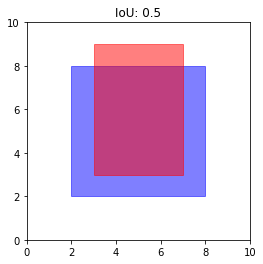

In [ ]:
def plot_IoU(boxA, boxB, img_size=(10, 10)):
    """Plot the IoU measure
    """
    iou = IoU(boxA, boxB)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_ylim(0, img_size[1])
    ax.set_xlim(0, img_size[0])
    ax.add_patch(plt.Rectangle((boxA[0], boxA[1]),
                               boxA[2] - boxA[0],
                               boxA[3] - boxA[1],
                               color='blue', alpha=0.5))
    ax.add_patch(plt.Rectangle((boxB[0], boxB[1]),
                               boxB[2] - boxB[0],
                               boxB[3] - boxB[1],
                               color='red', alpha=0.5))
    ax.set_title(f'IoU: {iou}')
    return fig, ax


fix, ax = plot_IoU([2, 2, 8, 8], [3, 3, 7, 9])
plt.show()


In [ ]:
num_classes

NameError: ignored

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
def classif_local_stupid_model():
    """Stupid model that averages all the spatial information
    
    The goal of this model is to show that it's a very bad idea to destroy
    the spatial information with GlobalAveragePooling2D layer if our
    goal is to do object localization.
    """
    model_input = Input(shape=(7, 7, 2048))
    x = GlobalAveragePooling2D()(model_input)
    x = Dropout(0.2)(x)
    x = Dense(1000)(x)
    head_classes = Dense(1, activation='sigmoid', name='head_classes')(x)
    head_boxes = Dense(4, name='head_boxes')(x)
    
    model = Model(inputs=model_input, outputs=[head_classes, head_boxes], name='resnet_loc')
    model.compile(optimizer='adam', loss=[binary_crossentropy, mean_squared_error], 
                  loss_weights=[1., 0.01])
    return model


In [ ]:
model = classif_local_stupid_model()
model.summary()

In [ ]:
num = 16
inputs = reprs[0:num]
out_cls, out_boxes = classes[0:num], boxes[0:num]

print(f'Input batch shape: {inputs.shape}')
print(f'Ground truth batch shapes: {out_cls.shape} and {out_boxes.shape}')


Input batch shape: (16, 7, 7, 2048)
Ground truth batch shapes: (16, 1) and (16, 4)


In [ ]:
out = model.predict(inputs)
print(f'Output model batch shapes: {out[0].shape} and {out[1].shape}')


Output model batch shapes: (16, 1) and (16, 4)


In [ ]:
history = model.fit(inputs, [out_cls, out_boxes], batch_size=10, epochs=10)

Epoch 1/10
2/2 [==============================] - 0s 9ms/step - loss: 120.6149 - head_classes_loss: 3.8987 - head_boxes_loss: 11671.6211
Epoch 2/10
2/2 [==============================] - 0s 9ms/step - loss: 17.4511 - head_classes_loss: 0.0000e+00 - head_boxes_loss: 1745.1128
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - loss: 42.1089 - head_classes_loss: 0.0000e+00 - head_boxes_loss: 4210.8887
Epoch 4/10
2/2 [==============================] - 0s 9ms/step - loss: 38.6629 - head_classes_loss: 0.0000e+00 - head_boxes_loss: 3866.2915
Epoch 5/10
2/2 [==============================] - 0s 9ms/step - loss: 12.3309 - head_classes_loss: 0.0000e+00 - head_boxes_loss: 1233.0872
Epoch 6/10
2/2 [==============================] - 0s 8ms/step - loss: 11.6712 - head_classes_loss: 0.0000e+00 - head_boxes_loss: 1167.1165
Epoch 7/10
2/2 [==============================] - 0s 9ms/step - loss: 20.4904 - head_classes_loss: 0.0000e+00 - head_boxes_loss: 2049.0410
Epoch 8/10
2/2 [============

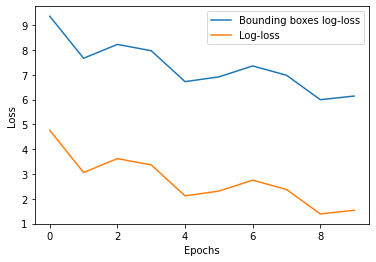

In [ ]:
plt.plot(np.log(history.history["head_boxes_loss"]), label="Bounding boxes log-loss")
#plt.plot(np.log(history.history["head_classes_loss"]), label="Classloss")
plt.plot(np.log(history.history["loss"]), label="Log-loss")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [ ]:
def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2] - bbox[0] + 1, bbox[3] - bbox[1] + 1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    axis.text(bbox[0], bbox[1], display_txt, color='white', bbox={'facecolor':color, 'alpha':0.5})
    
def plot_annotations(img_path, annotation=None, ground_truth=None):
    img = imread(img_path)
    plt.imshow(img)
    current_axis = plt.gca()
    if ground_truth:
        text = "GT " + "kangaroo"
        patch(current_axis, ground_truth["bbox"], text, "red")
    if annotation:
        conf = f'{annotation["confidence"][0]:0.2f} '
        text = conf + annotation["class"]
        patch(current_axis, annotation["bbox"], text, "blue")
    plt.axis('off')

def display(model, index, ground_truth=True):
    res = model.predict(reprs[index][np.newaxis])
    output = interpret_output(res[0][0], res[1][0], img_size=annotations[index]["size"])
    plot_annotations(os.path.join(IMG_DIR, annotations[index]["filename"]), 
                     output, annotations[index] if ground_truth else None)

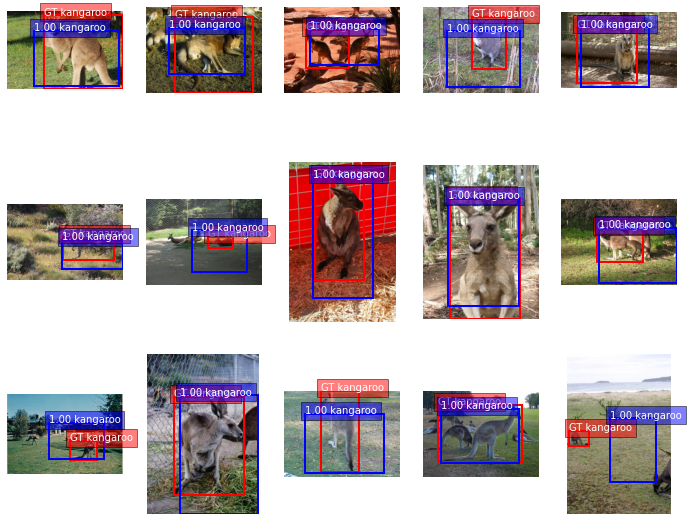

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    display(model, np.random.randint(reprs.shape[0]))
plt.show()


In [ ]:
def accuracy_and_iou(preds, trues, threshold=0.5):
    sum_valid, sum_accurate, sum_iou = 0, 0, 0
    num = len(preds)
    for pred, true in zip(preds, trues):
        iou_value = IoU(pred["bbox"], true["bbox"])
        if pred["class"] == true["class"] and iou_value > threshold:
            sum_valid = sum_valid + 1
        sum_iou = sum_iou + iou_value
        if pred["class"] == true["class"]:
            sum_accurate = sum_accurate + 1
    return sum_accurate / num, sum_iou / num, sum_valid / num


In [ ]:
def compute_acc(model, train=True):
    if train:
        beg, end = 0, (9 * len(annotations) // 10)
        split_name = "Train"
    else:
        beg, end = (9 * len(annotations)) // 10, len(annotations) 
        split_name = "Test"
    res = model.predict(reprs[beg:end])
    outputs = []
    for index, (classes, boxes) in enumerate(zip(res[0], res[1])):
        output = interpret_output(classes, boxes,
                                  img_size=annotations[index]["size"])
        outputs.append(output)
    
    acc, iou, valid = accuracy_and_iou(outputs, annotations[beg:end],
                                       threshold=0.5)
    
    print(f'{split_name} acc: {acc:0.3f}, mean IoU: {iou:0.3f}, acc_valid: {valid:0.3f}')



In [ ]:
compute_acc(model, train=True)
compute_acc(model, train=False)


Train acc: 0.000, mean IoU: 0.449, acc_valid: 0.000
Test acc: 0.000, mean IoU: 0.334, acc_valid: 0.000


In [ ]:
import tensorflow as tf
grid_size = 5
grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
grid

[<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
 array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]], dtype=int32)>,
 <tf.Tensor: shape=(5, 5), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4]], dtype=int32)>]

In [ ]:
grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
grid

In [ ]:
tf.cast(grid_size, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

In [ ]:
import numpy as np
import tensorflow as tf

x, y = np.array([1, 2, 3, 4]), np.array([5, 6, 7, 8])
d = tf.data.Dataset.from_tensors((x,y))
print(d) # > (TensorShape([4]), TensorShape([4]))
d_sliced = tf.data.Dataset.from_tensor_slices((x,y))
print(d_sliced) # > (TensorShape([]), TensorShape([])) 

<TensorDataset shapes: ((4,), (4,)), types: (tf.int64, tf.int64)>
<TensorSliceDataset shapes: ((), ()), types: (tf.int64, tf.int64)>


In [ ]:
list1 = list(range(1, 10, 2))
list2 = list1
list1[0] = 11
print(list1)
print(list2)

[111, 3, 5, 7, 9]
[111, 3, 5, 7, 9]
